# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

sum_sq    df         F    PR(>F)  p_val_adj
A1BG   0.122578  12.0  2.796490  0.003701   0.010364
AAAS   0.017527  12.0  0.944161  0.509517   0.596369
AACS   0.136394  12.0  2.729393  0.004508   0.012212
AADAT  0.057031  12.0  5.478881  0.000002   0.000016
AAGAB  0.043359  12.0  2.127609  0.026045   0.053640

In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = 'results/'

In [8]:
os.listdir(pb_dir_path)

['.ipynb_checkpoints',
 'ancova_3df_res.pkl',
 'ancova_perm_res.pkl',
 'ancova_res.pkl',
 'chimp_clusters_28.csv',
 'chimp_clusters_50.csv',
 'chimp_clusters_77.csv',
 'gene_selection_df.csv',
 'hs_anova_inter_clusters.csv',
 'hs_layers.csv',
 'hs_prof.csv',
 'hs_prof_anova.csv',
 'hs_ttest_inter_clusters.csv',
 'human_clusters_28.csv',
 'human_clusters_50.csv',
 'human_clusters_67.csv',
 'human_clusters_77.csv',
 'human_clusters_ancova.csv',
 'hum_spec_onehot.csv',
 'l1_distances.pkl',
 'macaque_clusters_28.csv',
 'macaque_clusters_77.csv',
 'mean_norm_clust_allgenes.csv',
 'optimal_model_res.pkl',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'specie_specific_genes_tr28.pkl',
 'specie_specific_genes_tr35.pkl',
 'specie_specific_genes_tr50.pkl',
 'specie_specific_genes_tr67.pkl',
 'specie_specific_genes_tr77.pkl',
 'zscore_norm_clust_allgenes.csv']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean_filtered.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 5390
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

5390

## Specie-specific genes

In [11]:
model_res = pd.read_csv('results/gene_selection_df.csv', index_col=0)
model_res.head()

human     chimp   macaque
AACS   0.001206  0.014287  0.318736
AAGAB  0.731575  0.661344  0.024143
AAK1   0.000658  0.699175  0.069657
AAMP   0.762617  0.530339  0.947528
AAR2   0.312623  0.436571  0.343371

In [12]:
import pickle
with open("results/ancova_perm_res.pkl", "rb") as file:
    ancova_results = pickle.load(file)

In [13]:
# import pickle
# with open("./results/specie_specific_genes_tr50.pkl", "rb") as file:
#     genes_dict77 = pickle.load(file)

In [14]:
sign_genes = {key:value[value['p-value'] < 0.05].index for key, value in ancova_results.items()}
sign_genes

{'human-chimp': Index(['ABCG4', 'ABHD6', 'ABI2', 'ABLIM3', 'ACHE', 'ACSL1', 'ACTG1', 'ACTN2',
        'ADAM15', 'ADGRB2',
        ...
        'ZEB2', 'ZFPL1', 'ZMYND8', 'ZNF32', 'ZNF362', 'ZNF608', 'ZNF689',
        'ZNF692', 'ZNF706', 'ZNF74'],
       dtype='object', length=786),
 'human-macaque': Index(['AACS', 'AAGAB', 'AAK1', 'AAR2', 'AARS1', 'AATK', 'ABAT', 'ABCC10',
        'ABCD4', 'ABHD10',
        ...
        'ZNF575', 'ZNF576', 'ZNF592', 'ZNF593', 'ZNF655', 'ZNF689', 'ZNF703',
        'ZNF706', 'ZNF768', 'ZNFX1'],
       dtype='object', length=2085),
 'chimp-macaque': Index(['AARS1', 'AATK', 'ABAT', 'ABCC10', 'ABCC8', 'ABCD4', 'ABHD10', 'ABLIM3',
        'ACAD9', 'ACADVL',
        ...
        'ZNF184', 'ZNF189', 'ZNF304', 'ZNF341', 'ZNF511', 'ZNF536', 'ZNF576',
        'ZNF655', 'ZNF689', 'ZNF703'],
       dtype='object', length=1562)}

Попробуем определить человеко-специфичные гены как $(HC\bigcap HM)\setminus CM$

In [15]:
hs_genes = sign_genes['human-chimp'].intersection(sign_genes['human-macaque']).difference(sign_genes['chimp-macaque'])
hs_genes, hs_genes.size

(Index(['ABHD6', 'ABI2', 'ADAM15', 'ADI1', 'ADORA1', 'AFTPH', 'AHNAK2', 'ALCAM',
        'AMFR', 'ANK2',
        ...
        'VIPAS39', 'VLDLR', 'WWP1', 'YWHAE', 'YWHAH', 'ZBTB18', 'ZBTB46',
        'ZEB2', 'ZNF362', 'ZNF706'],
       dtype='object', length=230),
 230)

## Helpful functions

In [16]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [17]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [18]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [171]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [172]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[hs_genes].copy()

## Hierarchial

D:\Projects\spatialMPFC\venv\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


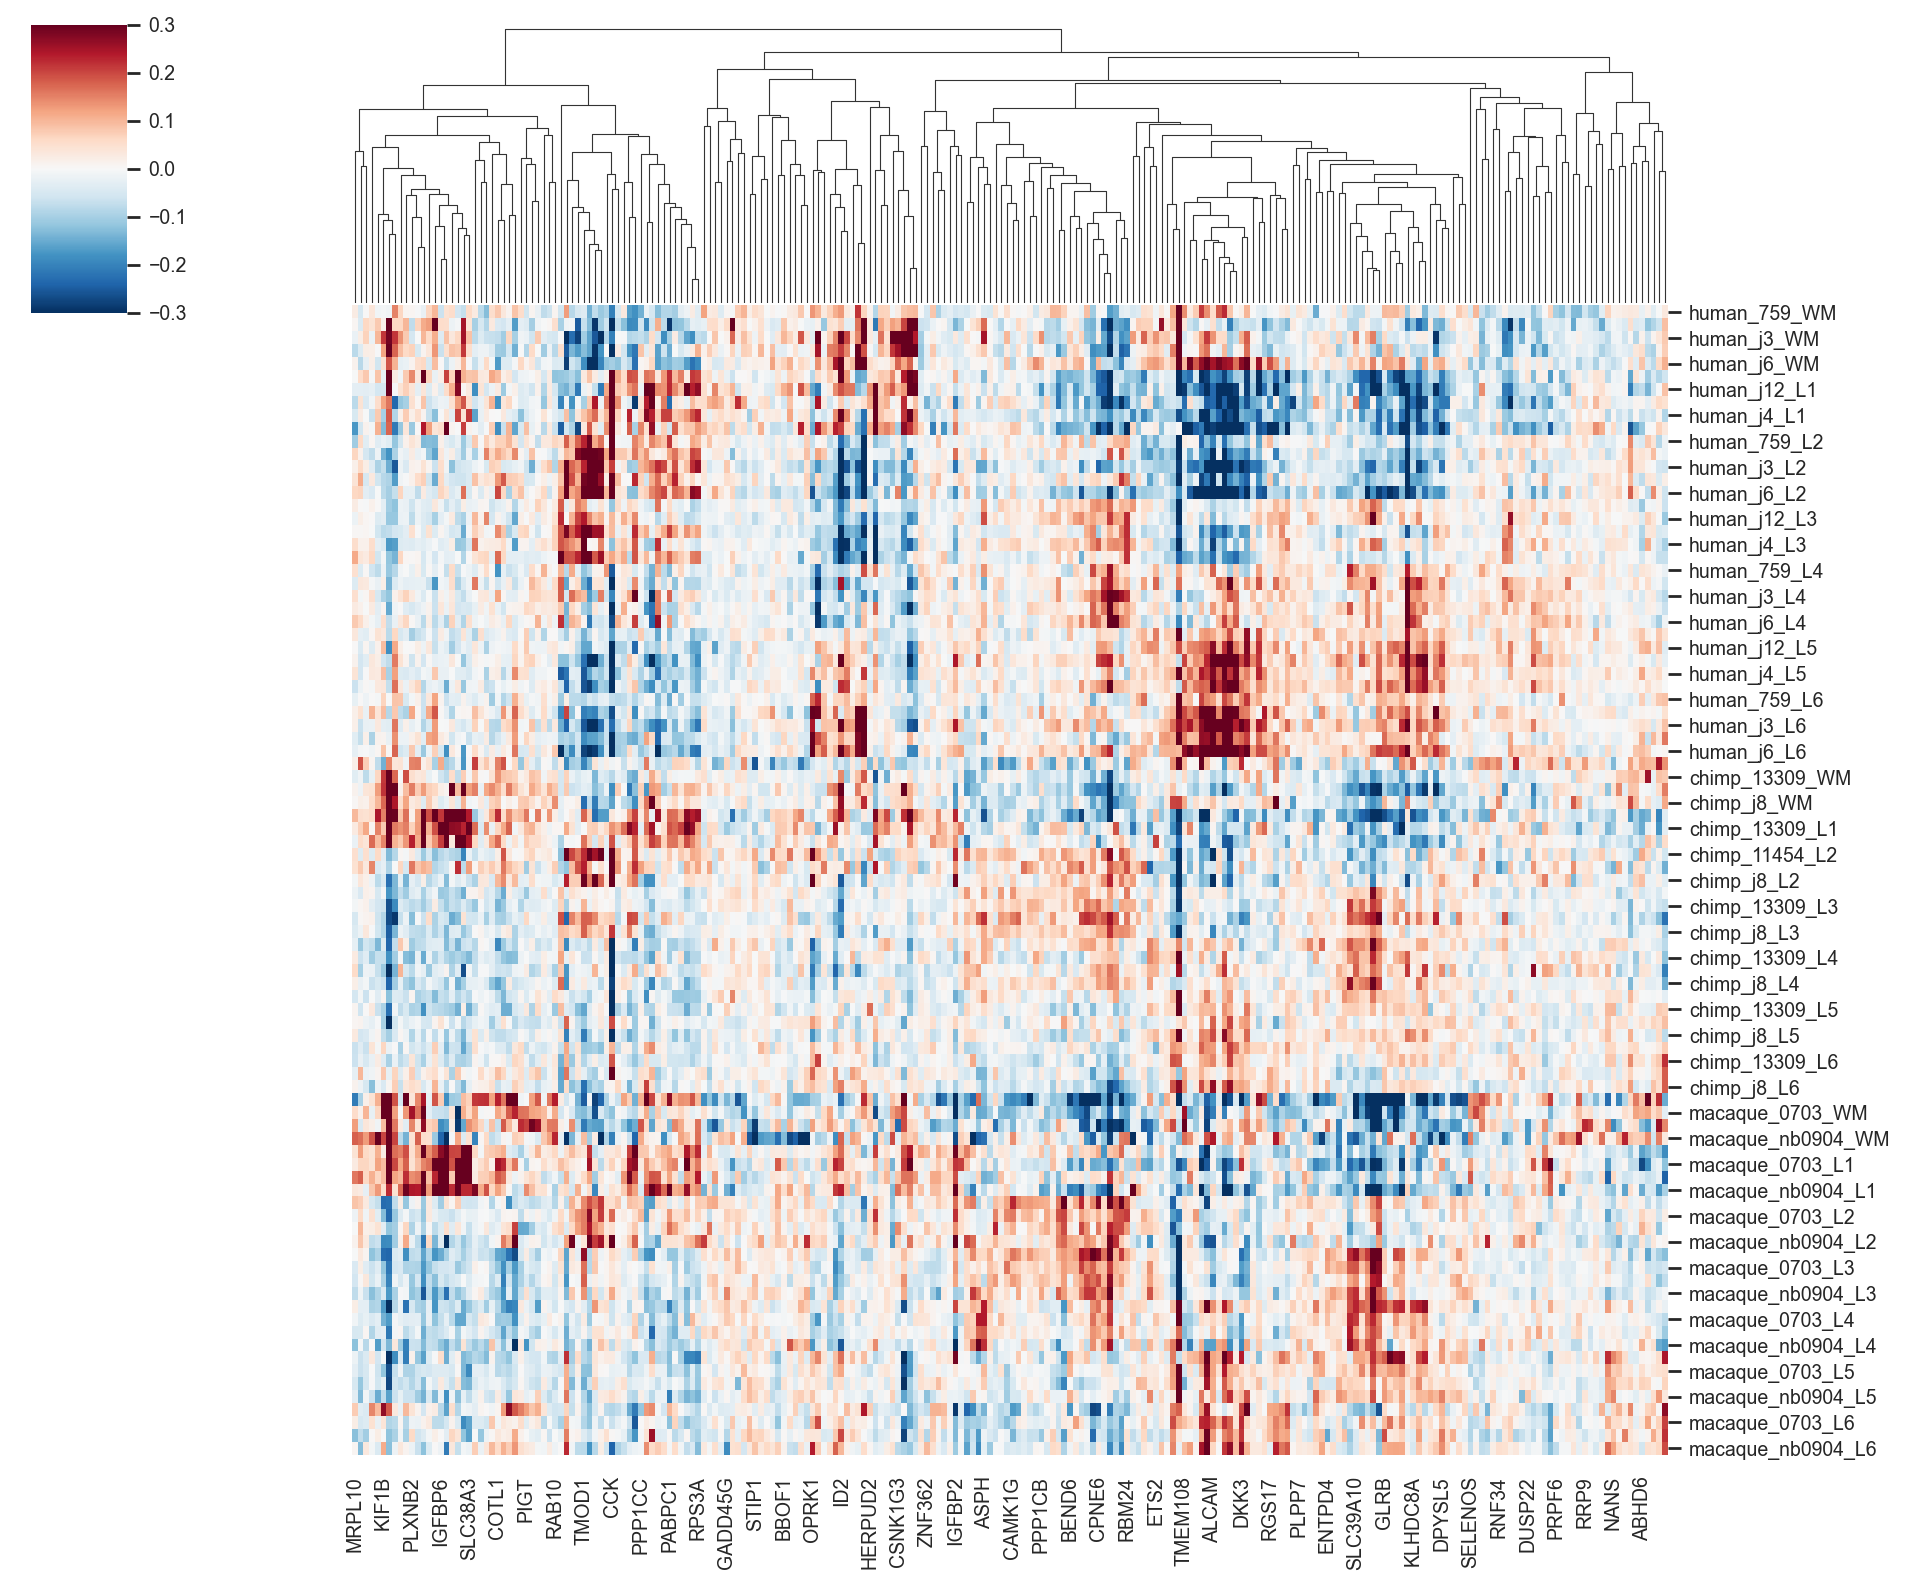

In [173]:
sns.set(font_scale=0.8)
sns.clustermap(df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

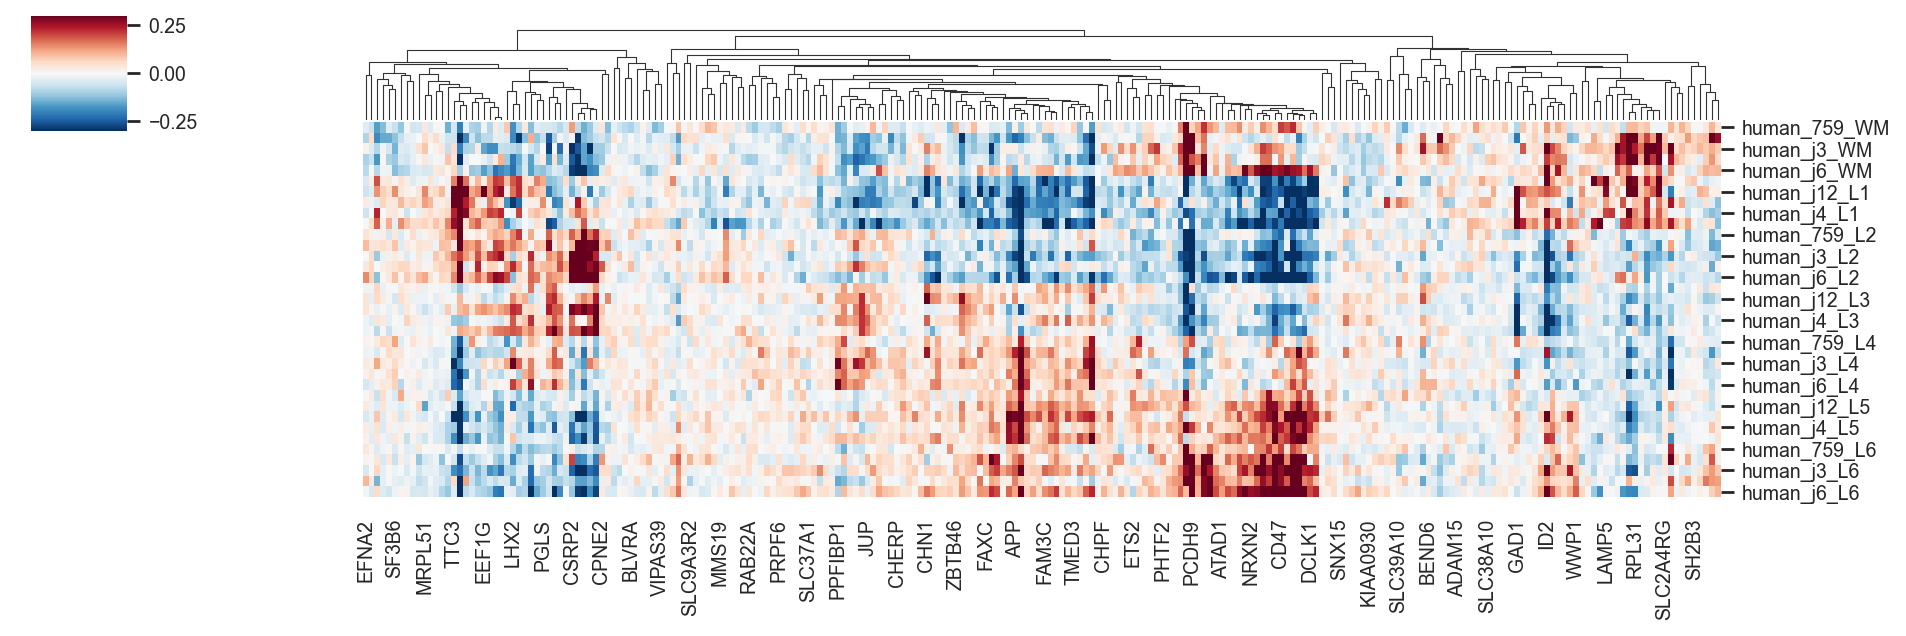

In [174]:
sns.clustermap(df_hs.loc[sample_order['human']], figsize=(12, 4), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [175]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
#aff_matrix = pairwise_kernels(df_hs.T[sample_order['human']], metric='cosine') + 1
n_clusters = 6
clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=4)
#clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=4)
#clustering.fit(aff_matrix)
clustering.fit(df_hs.T)

SpectralClustering(affinity='nearest_neighbors', n_clusters=6, random_state=4)

In [176]:
labels = pd.Series(clustering.labels_, index=hs_genes).sort_values()
order = labels.sort_values().index

In [177]:
labels.to_csv('./results/human_clusters_ancova.csv')

In [178]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [179]:
colors = cluster_color[:n_clusters]
clusters = np.arange(n_clusters)

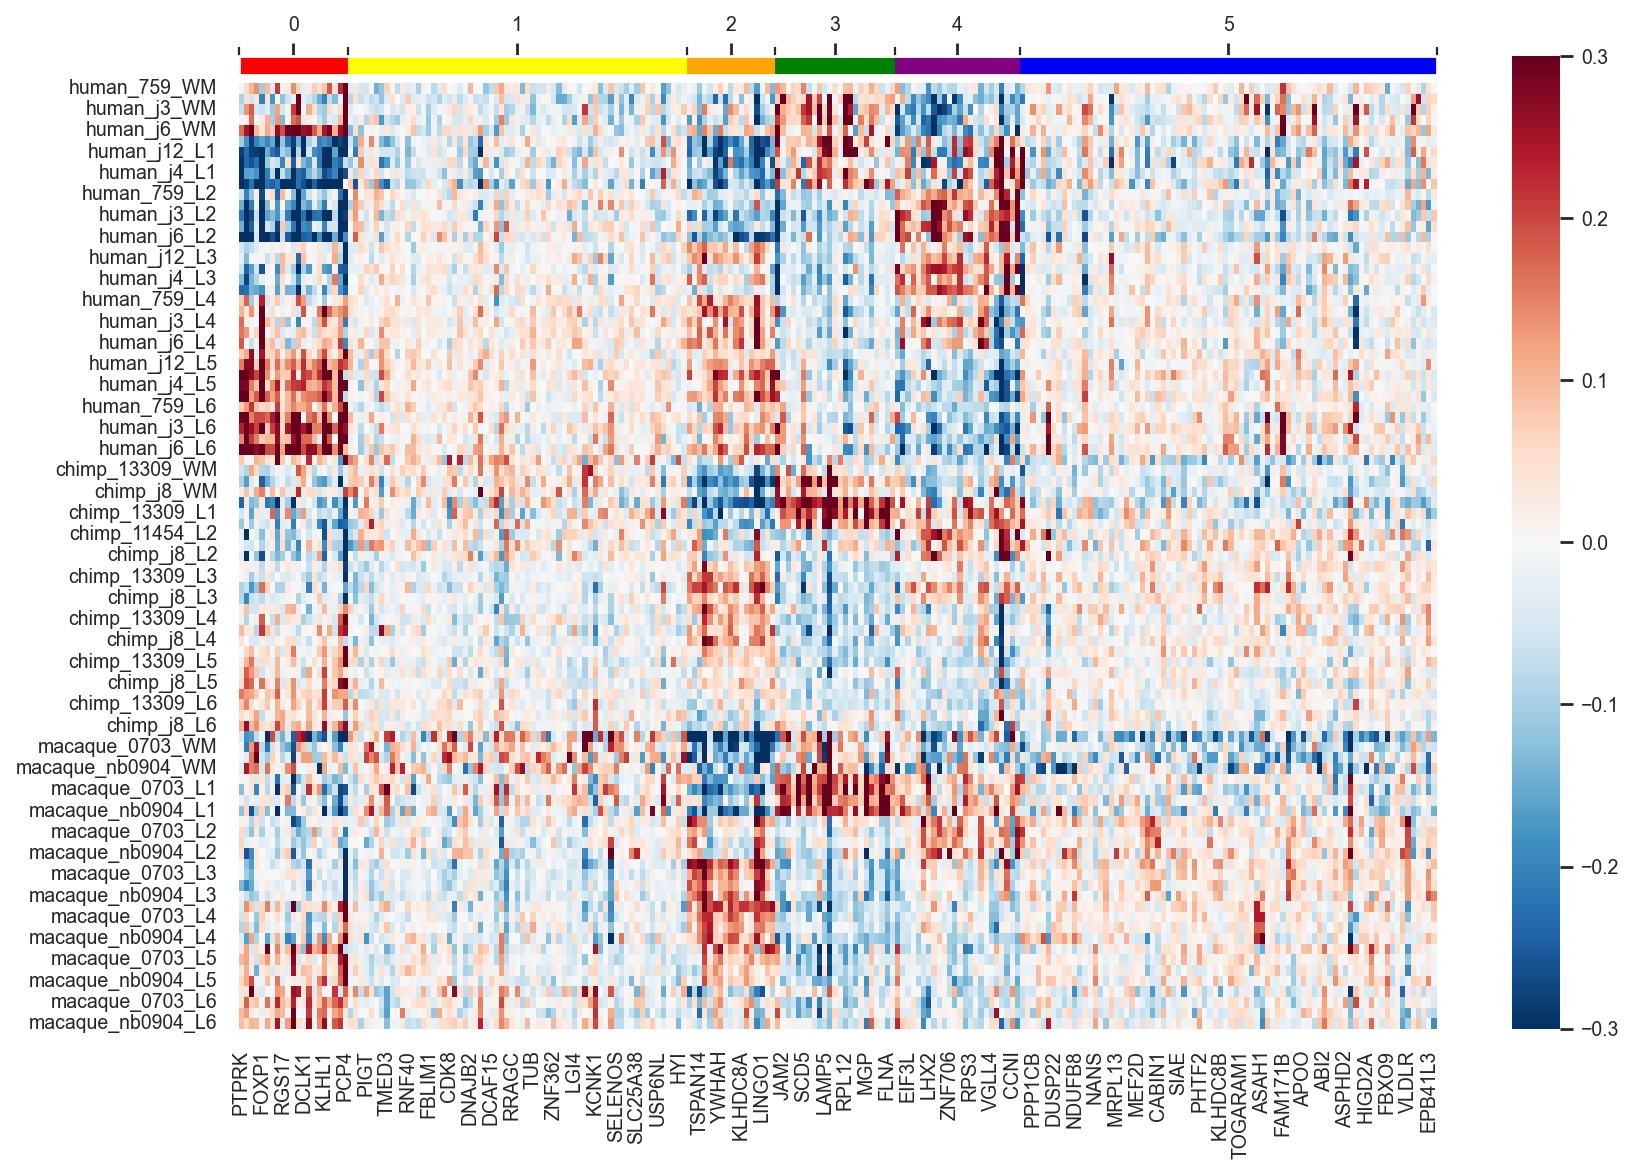

In [180]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_hs[order], ax=ax, cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

In [181]:
labels[labels == 1].size

65

## Cluster profiles

In [182]:
df_annotation = df_hs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [183]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ABHD6      ABI2    ADAM15      ADI1    ADORA1     AFTPH  \
condition layer                                                               
chimp     L1    -0.128820 -0.059771  0.120247  0.232106 -0.142581 -0.002926   
          L2     0.081598  0.010944 -0.003475 -0.029761 -0.145785  0.063356   
          L3    -0.039633  0.062355 -0.044347 -0.081698 -0.120843  0.044030   
          L4     0.020756  0.020539 -0.039034 -0.069586  0.006139  0.001397   
          L5     0.006443 -0.015000 -0.052907 -0.055009  0.065859 -0.012946   

                   AHNAK2     ALCAM      AMFR      ANK2  ...   VIPAS39  \
condition layer                                          ...             
chimp     L1    -0.091653  0.009130  0.083703 -0.074303  ... -0.059544   
          L2    -0.052059 -0.242804  0.070298 -0.107423  ...  0.045883   
          L3    -0.010910 -0.066325 -0.016274 -0.046509  ... -0.000079   
          L4     0.062326  0.006249 -0.060398 -0.037624  ...  0.029193   
          L5     0.082473  0.134409 -0.049253 -0.015614  ... -0.027980   

                    VLDLR      WWP1     YWHAE     YWHAH    ZBTB18    ZBTB46  \
condition layer                                                               
chimp     L1    -0.015714 -0.021681 -0.043822 -0.213943 -0.154330  0.026107   
          L2     0.094521  0.075032  0.006897 -0.006026  0.229193  0.072883   
          L3     0.069694 -0.028285  0.031802  0.053368  0.178206  0.070541   
          L4    -0.048778 -0.005638  0.006790  0.066827  0.129230  0.024286   
          L5    -0.039212  0.002174  0.007214  0.060298  0.023022 -0.064324   

                     ZEB2    ZNF362    ZNF706  
condition layer                                
chimp     L1     0.037896  0.034277  0.020416  
          L2     0.051170 -0.024460  0.121583  
          L3    -0.040480  0.001123  0.067006  
          L4    -0.075607 -0.028787 -0.001815  
          L5    -0.057856  0.018199 -0.035676  

[5 rows x 230 columns]

In [184]:
# fig, axes = plt.subplots(2, 2,  figsize=(14, 3.5 * 2), gridspec_kw={'hspace': 0.4})
# for gene, ax in zip(layer_mean.columns, axes.flatten()):
#     (
#             layer_mean[gene]
#             .reorder_levels(['layer', 'condition'])
#             .unstack().loc[layers]
#             .plot
#             .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
#     )
#     ax.grid(False)

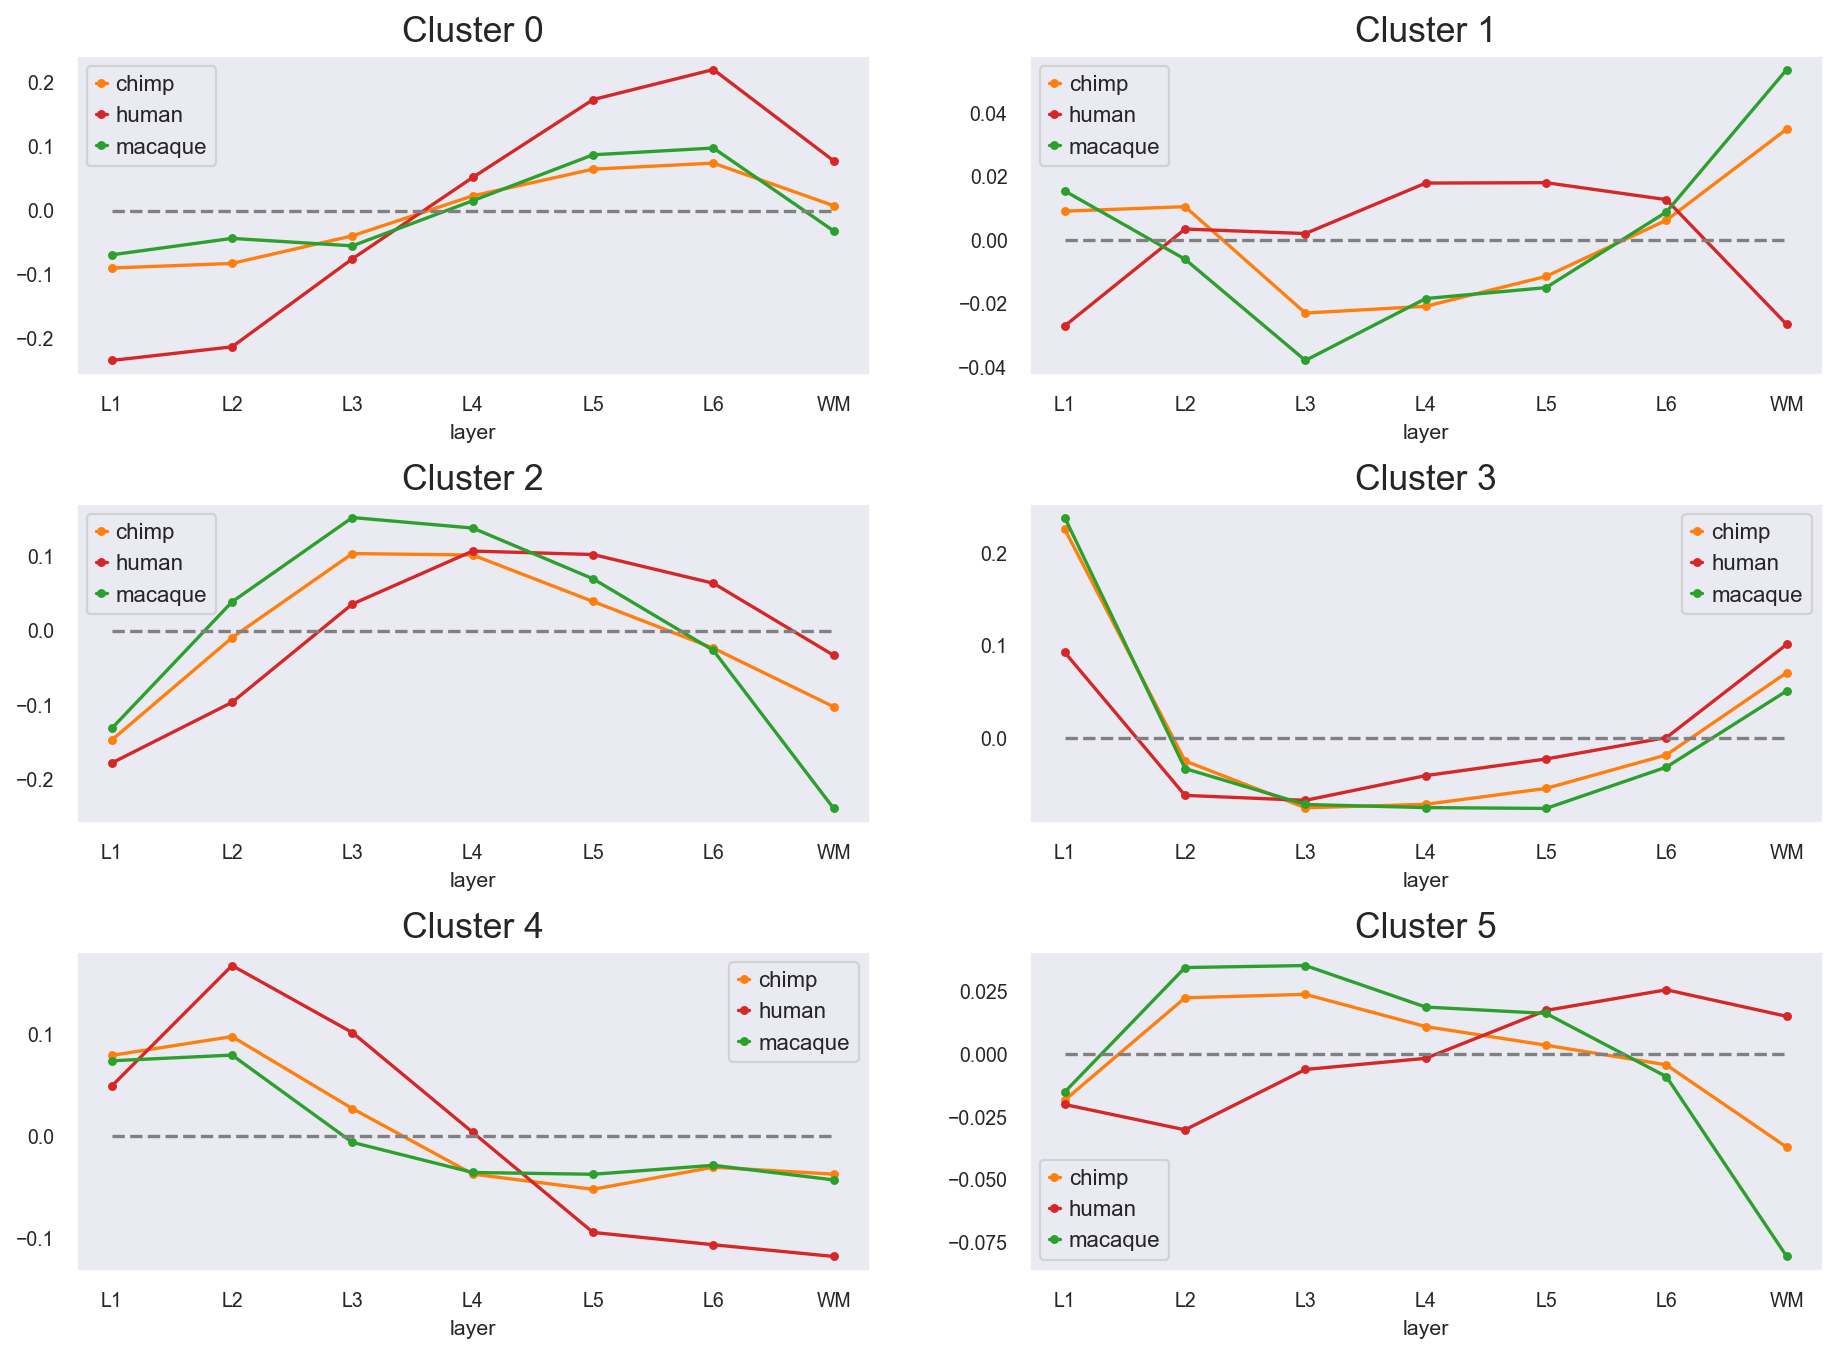

In [185]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

Text(0.5, 0.98, 'Median everaging for profiles')

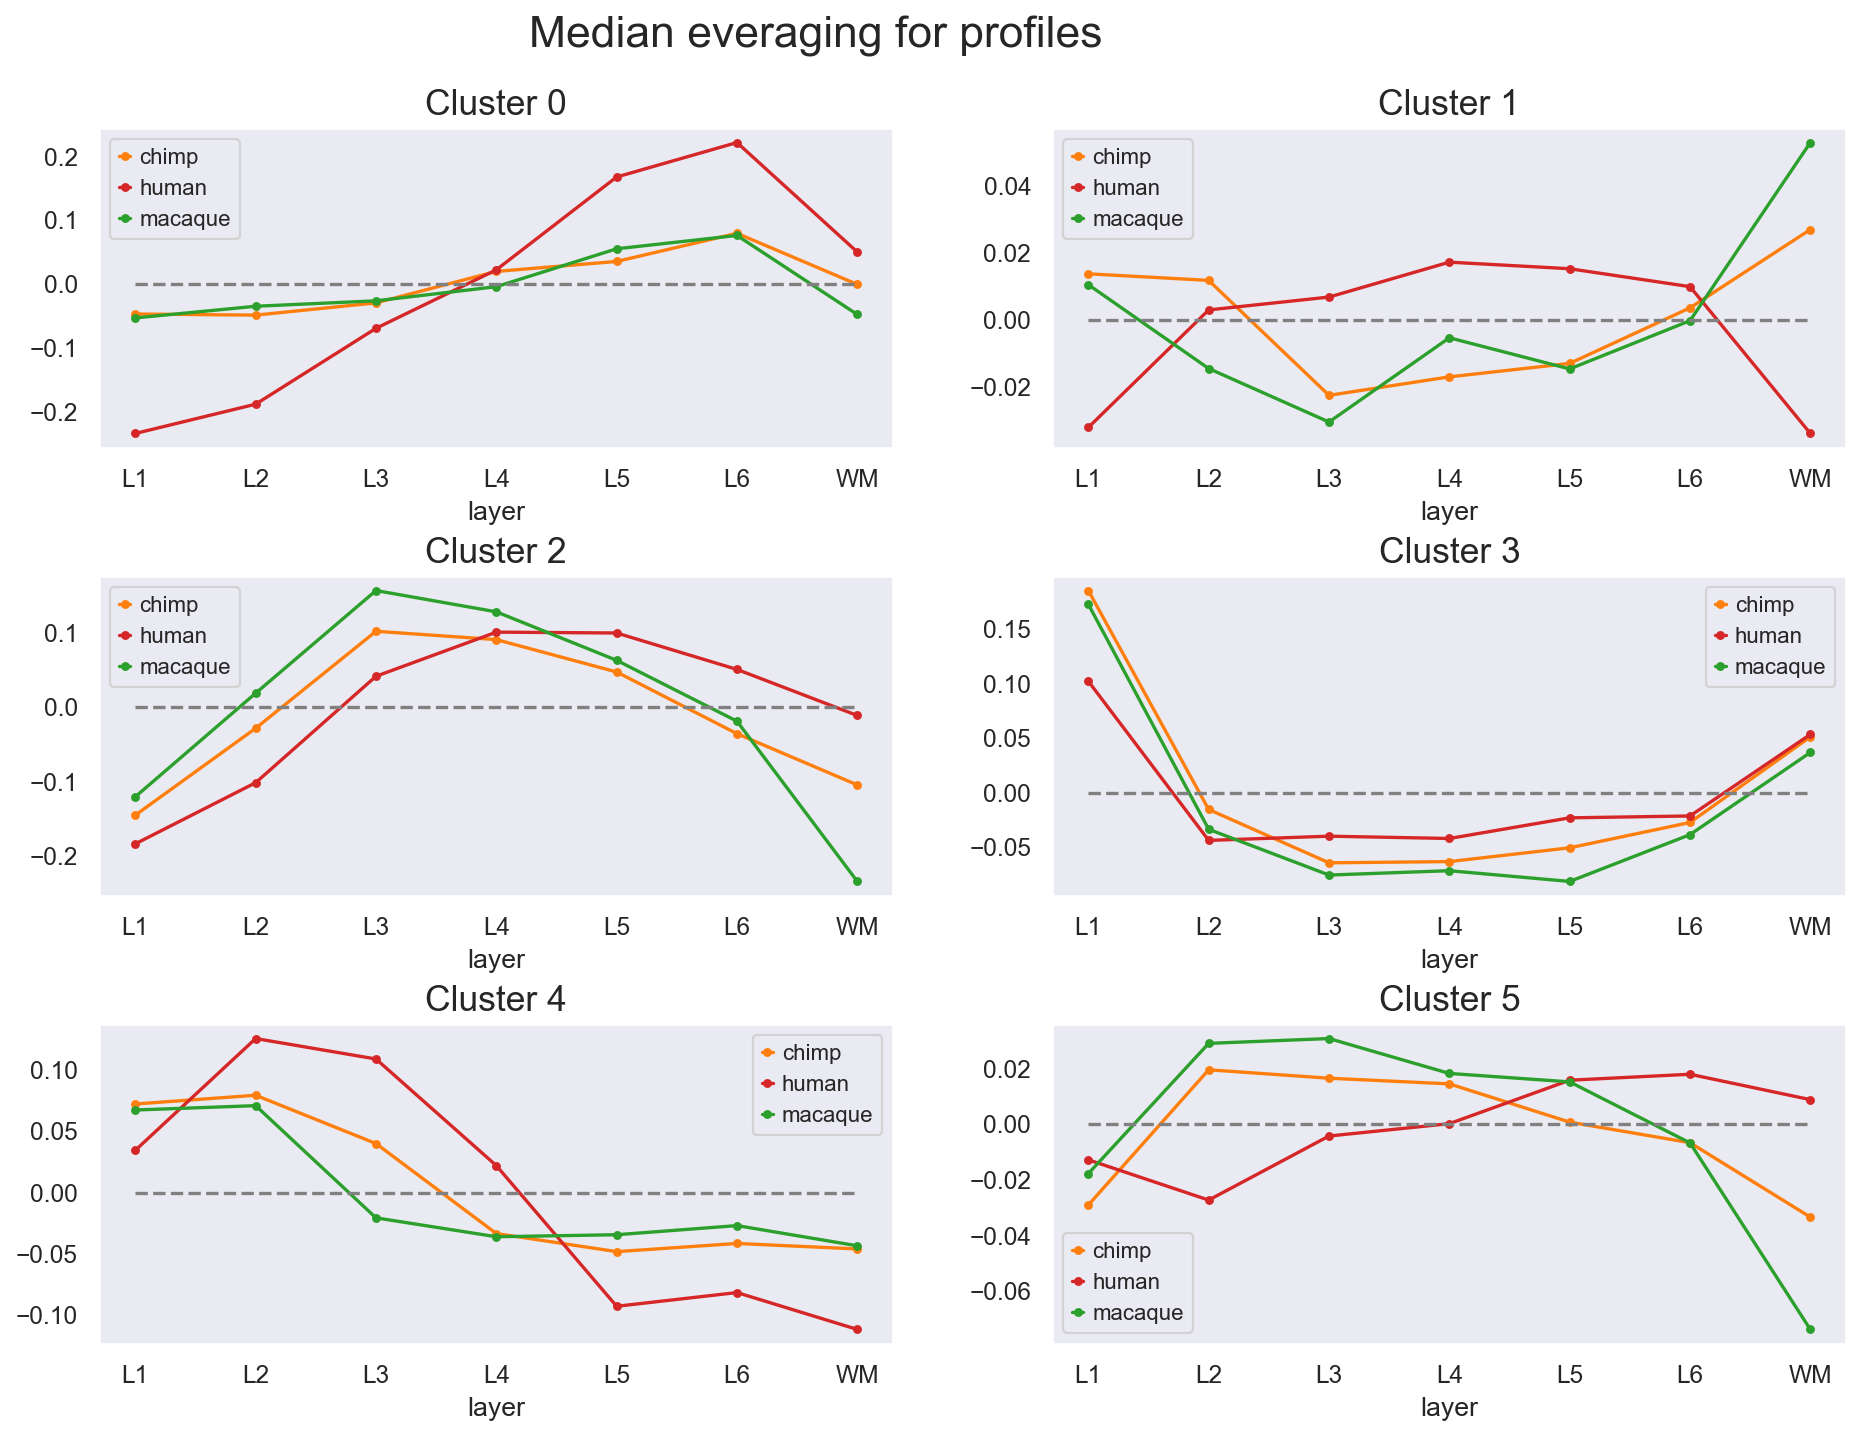

In [186]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median everaging for profiles', fontsize=20)

# 4 Species

In [187]:
pb_dir_path = '../../data/pseudobulks/'
adata_pb_4spe = sc.read_h5ad(pb_dir_path + '4spe_pb_mean_filt_nor_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_4spe

AnnData object with n_obs × n_vars = 116 × 6523
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'
    var: 'gene_name'
    uns: 'log1p'

In [188]:
df_4spe = pd.DataFrame(adata_pb_4spe.X, index=adata_pb_4spe.obs_names, columns=adata_pb_4spe.var_names)

In [189]:
hs_genes_inter = df_4spe.columns.intersection(hs_genes)
hs_genes_inter.size

154

In [190]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque', 'treeshrew']:
    samples = df_4spe.loc[df_4spe.index.str.contains(cond)].index
    order_s = sorted(samples.tolist(), key=lambda x: x[:2])
    order_laminar = list(filter(lambda x: 'L' in x, order_s))
    order_wm = list(filter(lambda x: 'WM' in x, order_s))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque'] + sample_order['treeshrew']
df_4spe = df_4spe.loc[sample_order['all']]
df_4spe_hs = df_4spe[hs_genes_inter]

In [191]:
order_4spe = order.intersection(hs_genes_inter)

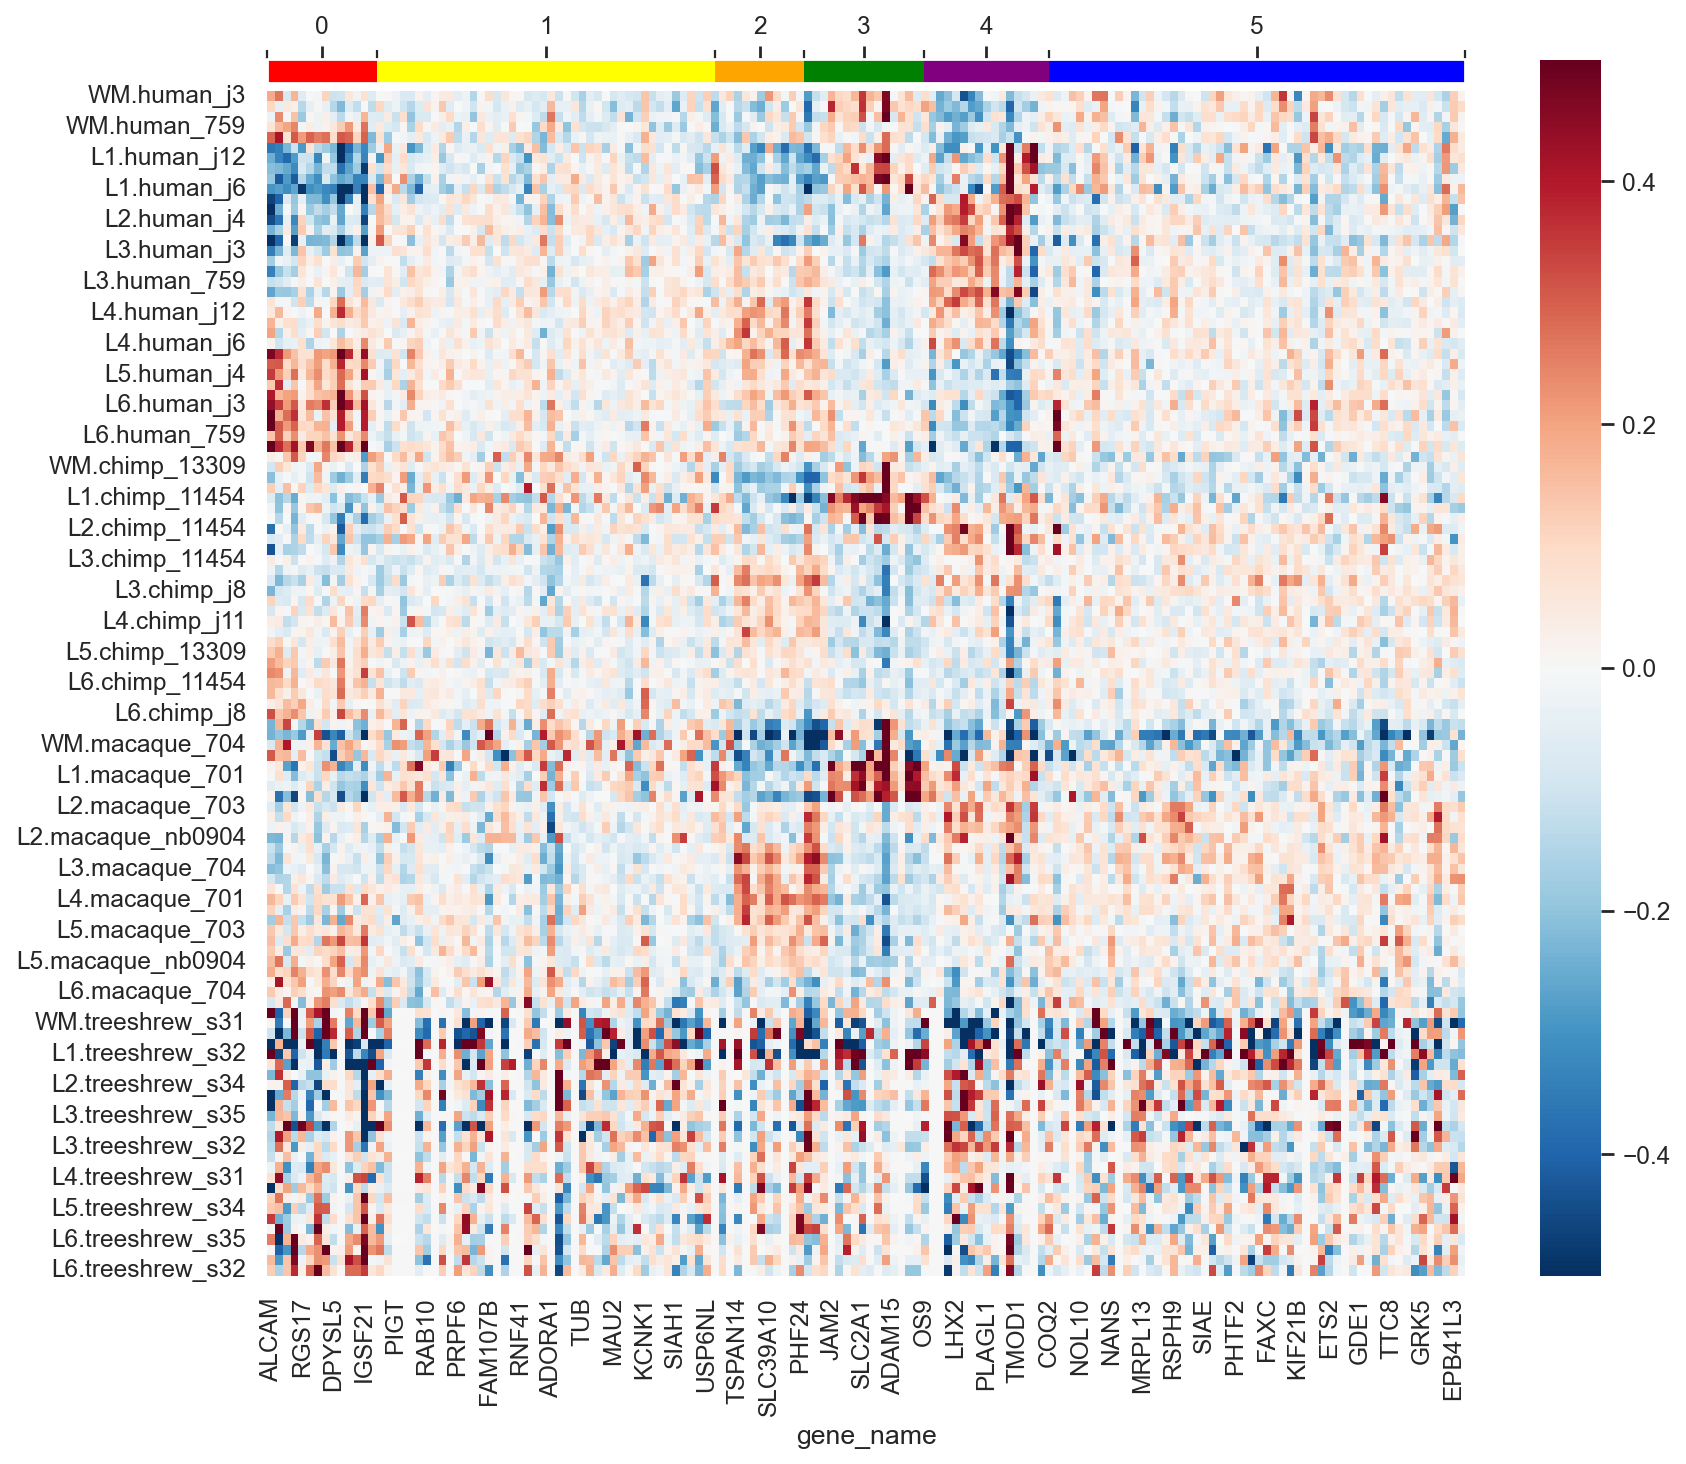

In [192]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_4spe_hs[order_4spe], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

## Cluster profiles (mean)

In [193]:
df_annotation = df_4spe_hs.copy()
df_annotation['layer'] = adata_pb_4spe.obs.layer
df_annotation['condition'] = adata_pb_4spe.obs.condition

In [194]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

gene_name          GPR153    FBLIM1    IGSF21    ZNF362    SLC2A1       HYI  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1     0.170319  0.080998 -0.231617  0.064203  0.549012  0.095937   
          L2     0.103709 -0.076954 -0.164320 -0.014871 -0.105929  0.035265   
          L3     0.135652  0.004237 -0.013440  0.000755 -0.085139 -0.019817   
          L4    -0.021479 -0.004656  0.176425 -0.038331 -0.159376 -0.102893   

gene_name          ADAM15    KIF21B    ADORA1   KLHDC8A  ...      GNAZ  \
condition layer                                          ...             
chimp     6a          NaN       NaN       NaN       NaN  ...       NaN   
          L1     0.142487 -0.061434 -0.160815 -0.203626  ... -0.039300   
          L2    -0.007318  0.055080 -0.223321 -0.038123  ...  0.123926   
          L3    -0.062504  0.114423 -0.185453  0.010068  ...  0.102861   
          L4    -0.046611  0.066458 -0.005093  0.023488  ...  0.079627   

gene_name          CABIN1    ASPHD2      TSPO  KIAA0930    PLXNB2     NCAM2  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1     0.007308 -0.039383  0.156637  0.000218  0.229904  0.075177   
          L2     0.034510  0.071358 -0.074830 -0.029361  0.058206  0.041594   
          L3     0.015382  0.092665 -0.067673 -0.041037 -0.121396 -0.014084   
          L4    -0.018344  0.007259 -0.098315 -0.017627 -0.165143 -0.011287   

gene_name            JAM2       APP      ETS2  
condition layer                                
chimp     6a          NaN       NaN       NaN  
          L1     0.285189 -0.117498  0.189577  
          L2    -0.111063 -0.100191 -0.086869  
          L3    -0.064058  0.082678 -0.065697  
          L4    -0.068254  0.083122  0.099880  

[5 rows x 154 columns]

Text(0.5, 0.98, 'Mean everaging for profiles')

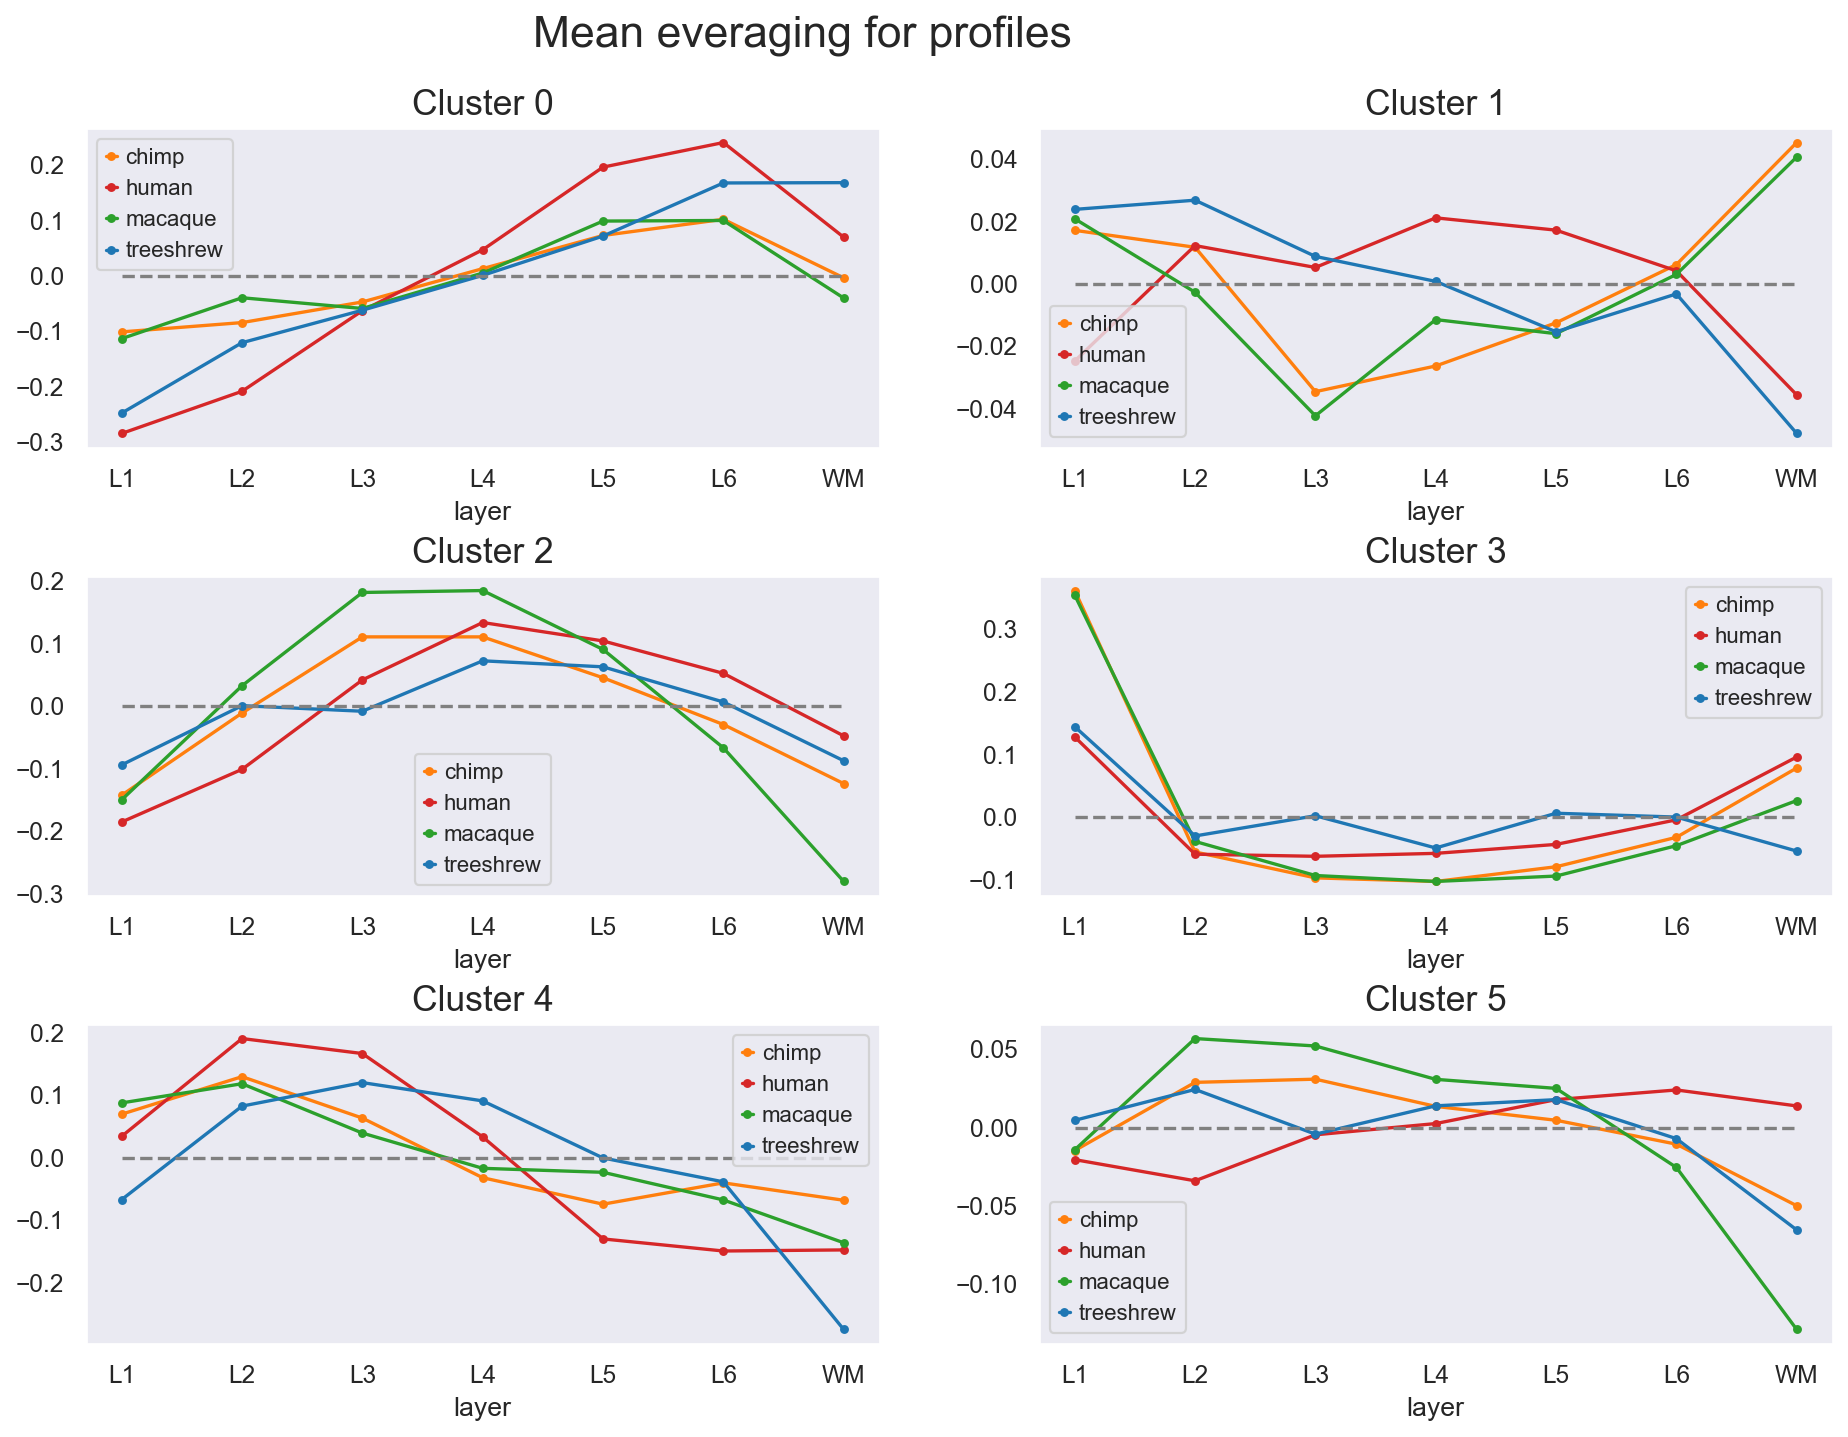

In [195]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(hs_genes_inter).tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Mean everaging for profiles', fontsize=20)

## Cluster profiles (Median)

Text(0.5, 0.98, 'Median everaging for profiles')

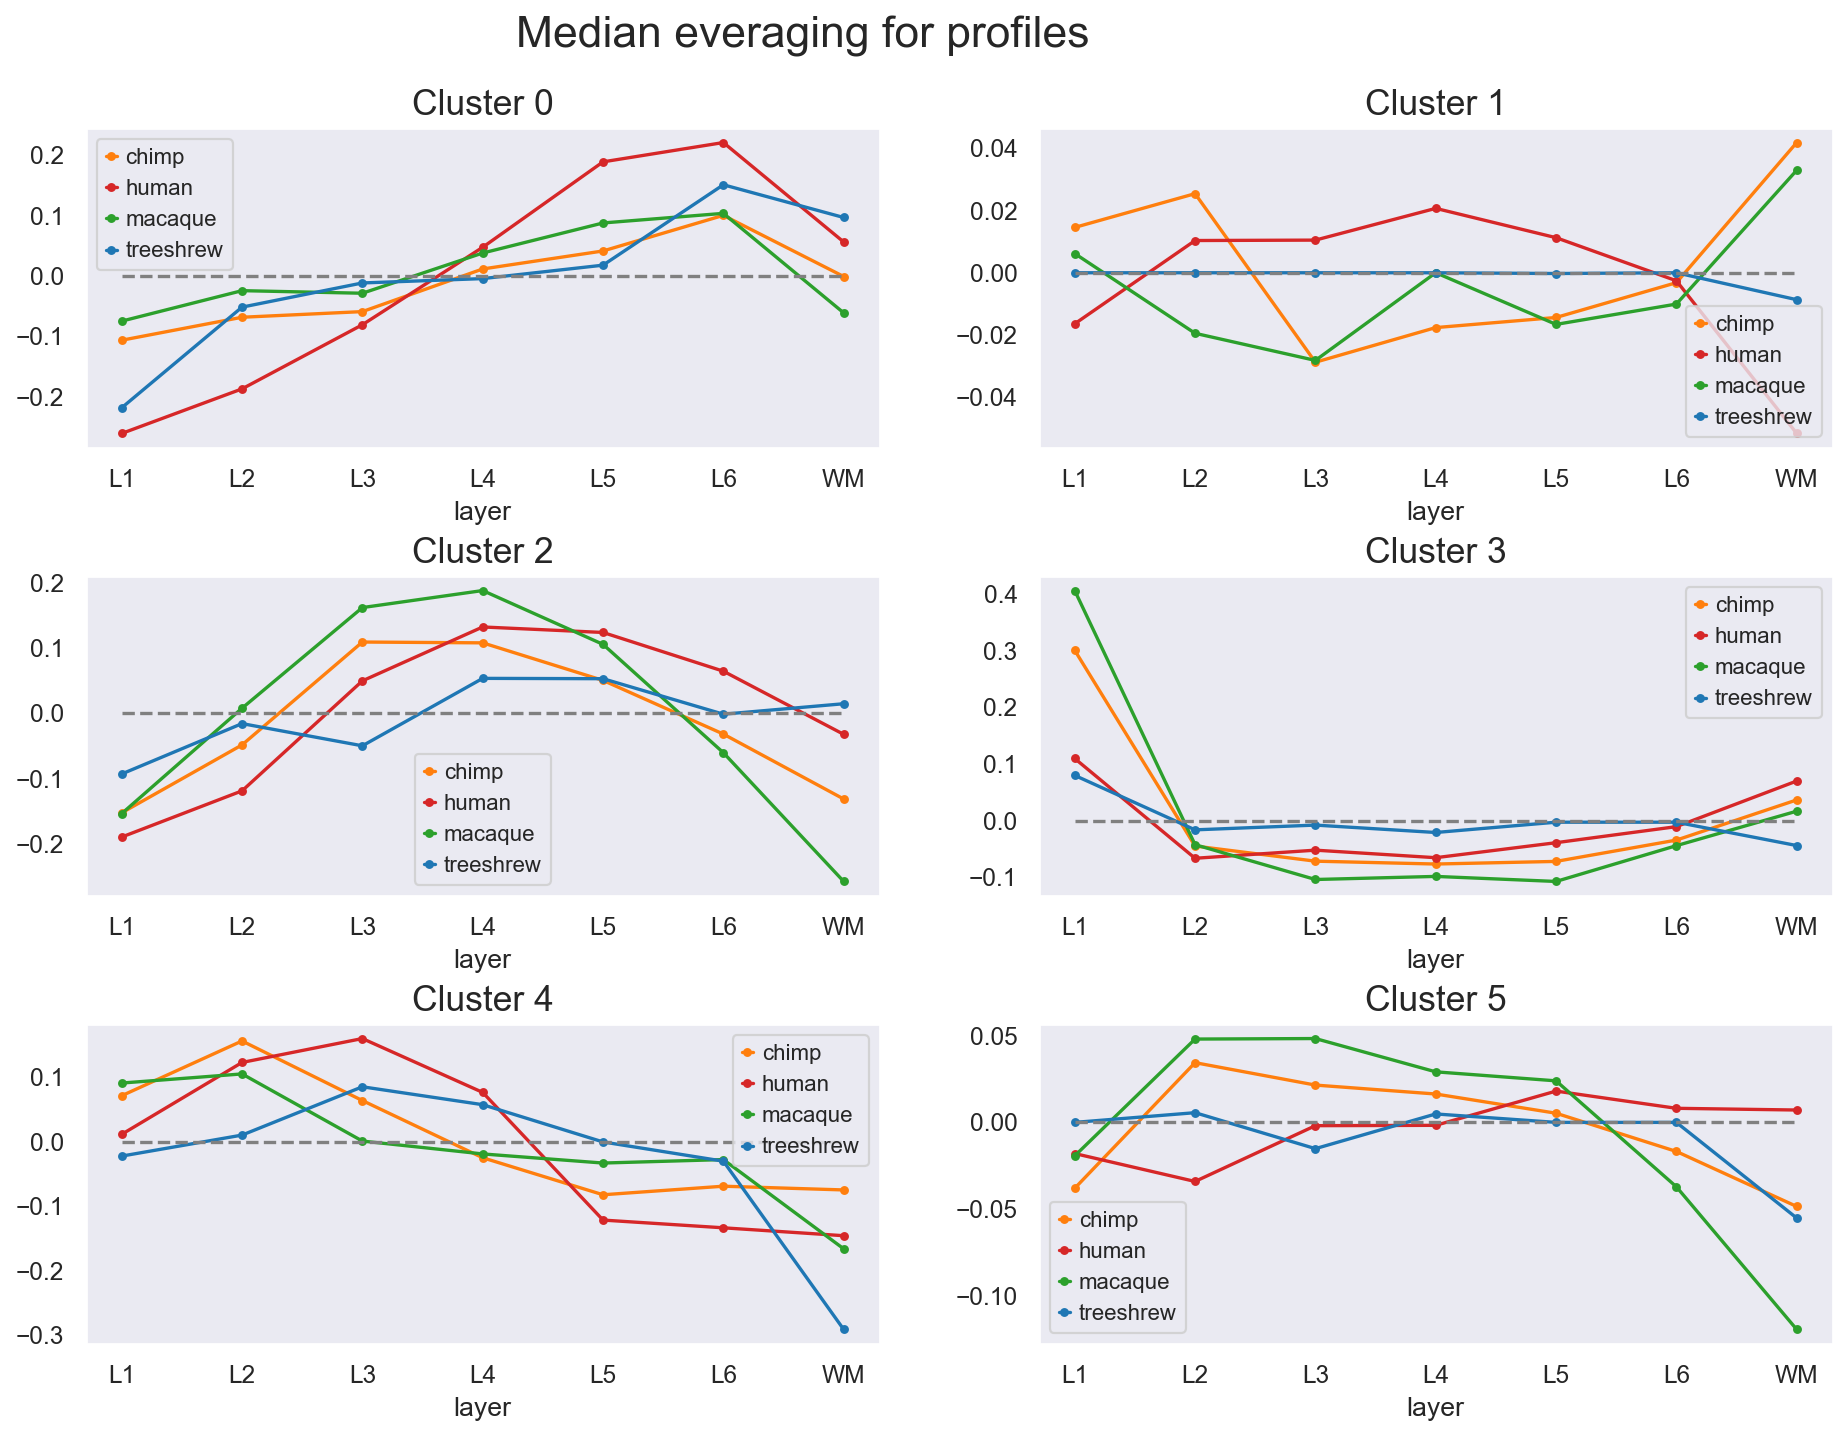

In [196]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(hs_genes_inter).tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median everaging for profiles', fontsize=20)

In [197]:
# sns.set(font_scale=1)
# label = 3
# genes = hs_genes_inter.tolist()
# fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * len(genes) // 2), gridspec_kw={'hspace': 0.4})

# for gene, ax in zip(genes, axes.flatten()):
#     (
#         layer_mean[gene]
#         .reorder_levels(['layer', 'condition'])
#         .unstack().loc[layers]
#         .plot
#         .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
#     )
#     ax.legend(fontsize=10)
#     ax.set_title(f'{gene}', fontsize=16)
#     ax.grid(False)
#     ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')
# plt.savefig('hs_genes_profiles.pdf')

In [198]:
cs_genes = sign_genes['chimp-macaque'].intersection(sign_genes['human-chimp']).difference(sign_genes['human-macaque'])
cs_genes, cs_genes.size

(Index(['ACHE', 'ACTN2', 'ANK3', 'ANKIB1', 'ARF5', 'ARID4A', 'ARID4B', 'AZIN2',
        'BAIAP2', 'BTF3', 'CAMK2G', 'COBL', 'CTDNEP1', 'DCAKD', 'DCBLD2',
        'DENND4B', 'DNAJB6', 'DYNC1I2', 'DYNC1LI1', 'ENOX1', 'FAM71E1',
        'FAM76A', 'FAU', 'GIPC1', 'GOLPH3', 'HCCS', 'HEY1', 'HINT1', 'HINT2',
        'HMGCLL1', 'HNRNPA3', 'HSPB11', 'KCNC2', 'KLF3', 'KXD1', 'LCMT1',
        'LRP3', 'LSM5', 'MAP3K7', 'METTL5', 'MGST3', 'MICU1', 'MIF', 'MORN4',
        'MRPL23', 'MRPL37', 'MRPS36', 'MYCBP2', 'NCOA3', 'NELL2', 'NETO1',
        'NUAK1', 'NUBP2', 'NUDCD1', 'NUP93', 'PARP8', 'PBRM1', 'PDE4B',
        'PITHD1', 'PLCB1', 'PML', 'POLR2C', 'PRXL2B', 'PTOV1', 'RADX',
        'RASL11B', 'RETREG1', 'RIPOR2', 'RNF2', 'RPL10', 'RPL35A', 'RPL5',
        'RPS16', 'RPS29', 'RPS5', 'RSL24D1', 'SCRN3', 'SDHD', 'SEC13', 'SEMA3A',
        'SERPINE2', 'SGTB', 'SLIRP', 'SORL1', 'SPP1', 'SRI', 'STARD4', 'STT3B',
        'SULF1', 'TAGLN2', 'TBC1D24', 'TMEM259', 'TSPAN3', 'UQCRH', 'USP11',
        'UTP1

In [199]:
cs_genes_inter = df_4spe.columns.intersection(cs_genes)
cs_genes_inter.size

60

In [200]:
df_4spe_cs = df_4spe[cs_genes_inter]

In [201]:
df_annotation = df_4spe_cs.copy()
df_annotation['layer'] = adata_pb_4spe.obs.layer
df_annotation['condition'] = adata_pb_4spe.obs.condition

In [202]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

gene_name          ZBTB17    PITHD1    FAM76A     AZIN2     UTP11    MRPL37  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.050830 -0.120021  0.093791 -0.024870  0.016716 -0.060008   
          L2    -0.031148 -0.037826  0.083384 -0.028452 -0.011984 -0.031085   
          L3    -0.019490 -0.019130 -0.004356  0.008705 -0.029310 -0.010805   
          L4    -0.021841  0.018376 -0.105385  0.011918  0.001102 -0.011301   

gene_name           PDE4B       WLS   DENND4B     MGST3  ...     NUP93  \
condition layer                                          ...             
chimp     6a          NaN       NaN       NaN       NaN  ...       NaN   
          L1    -0.020838  0.160677  0.096483 -0.050735  ...  0.118650   
          L2    -0.028034 -0.048604 -0.009262 -0.145839  ...  0.011037   
          L3     0.034972 -0.151951 -0.000121 -0.013848  ...  0.038760   
          L4     0.051433 -0.048296 -0.028336  0.071119  ... -0.023170   

gene_name           DCAKD    BAIAP2     NETO1     PLCB1     WFDC2     NCOA3  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1     0.135104 -0.186372 -0.120203 -0.194523  0.102305  0.074538   
          L2     0.033378 -0.075413 -0.174555 -0.246275  0.002262  0.038630   
          L3    -0.059487  0.008780 -0.091121  0.037518 -0.028534 -0.009224   
          L4    -0.059855 -0.008087  0.010843  0.097284 -0.014523 -0.003903   

gene_name         TMEM259      LRP3     PTOV1  
condition layer                                
chimp     6a          NaN       NaN       NaN  
          L1    -0.031654  0.179930 -0.056096  
          L2    -0.020200  0.180120  0.023434  
          L3     0.003608  0.145959  0.020639  
          L4    -0.025835  0.002809 -0.029804  

[5 rows x 60 columns]

In [203]:
# sns.set(font_scale=1)
# label = 3
# genes = cs_genes_inter.tolist()
# fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * len(genes) // 2), gridspec_kw={'hspace': 0.4})

# for gene, ax in zip(genes, axes.flatten()):
#     (
#         layer_mean[gene]
#         .reorder_levels(['layer', 'condition'])
#         .unstack().loc[layers]
#         .plot
#         .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
#     )
#     ax.legend(fontsize=10)
#     ax.set_title(f'{gene}', fontsize=16)
#     ax.grid(False)
#     ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')
# plt.savefig('cs_genes_profiles.pdf')

# Intersection with ANOVA clusters

In [204]:
anova_hs_inter = hs_genes.intersection(anova_labels.index)
anova_hs_inter

Index(['ABHD6', 'ABI2', 'ADAM15', 'ADI1', 'ADORA1', 'AFTPH', 'AHNAK2', 'ALCAM',
       'ANK2', 'APOO',
       ...
       'VGLL4', 'VIPAS39', 'VLDLR', 'WWP1', 'YWHAE', 'YWHAH', 'ZBTB18',
       'ZBTB46', 'ZEB2', 'ZNF706'],
      dtype='object', length=210)

In [205]:
table_to_pivot = pd.concat([anova_labels.loc[anova_hs_inter], labels.loc[anova_hs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'hs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

hs_labels        0     1     2     3     4     5
ANOVA_labels                                    
0              0.0   9.0   0.0   0.0  19.0   0.0
1              2.0   7.0   2.0   0.0   0.0   9.0
2             19.0  15.0   4.0   0.0   0.0  16.0
3              0.0  11.0   0.0   0.0   0.0   1.0
4              0.0   3.0   0.0   1.0   0.0   7.0
5              0.0   1.0  11.0   0.0   2.0  32.0
6              0.0   8.0   0.0  21.0   2.0   8.0

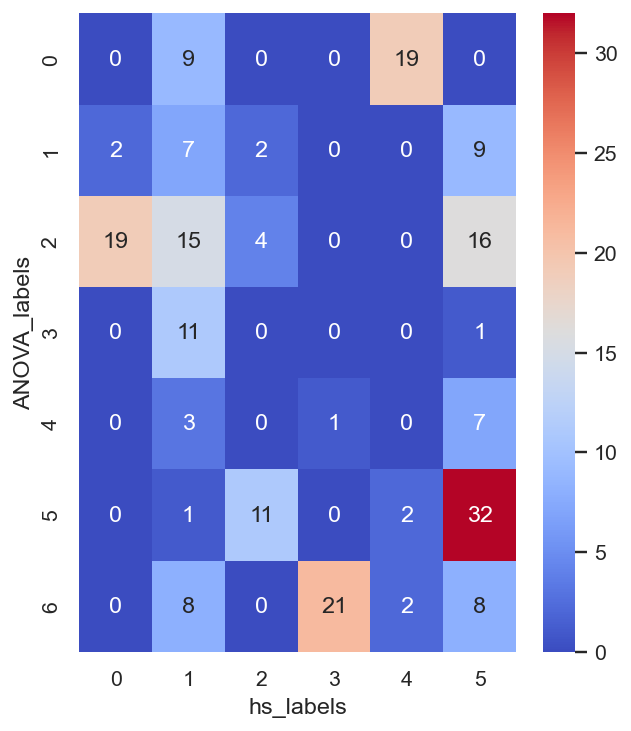

In [206]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

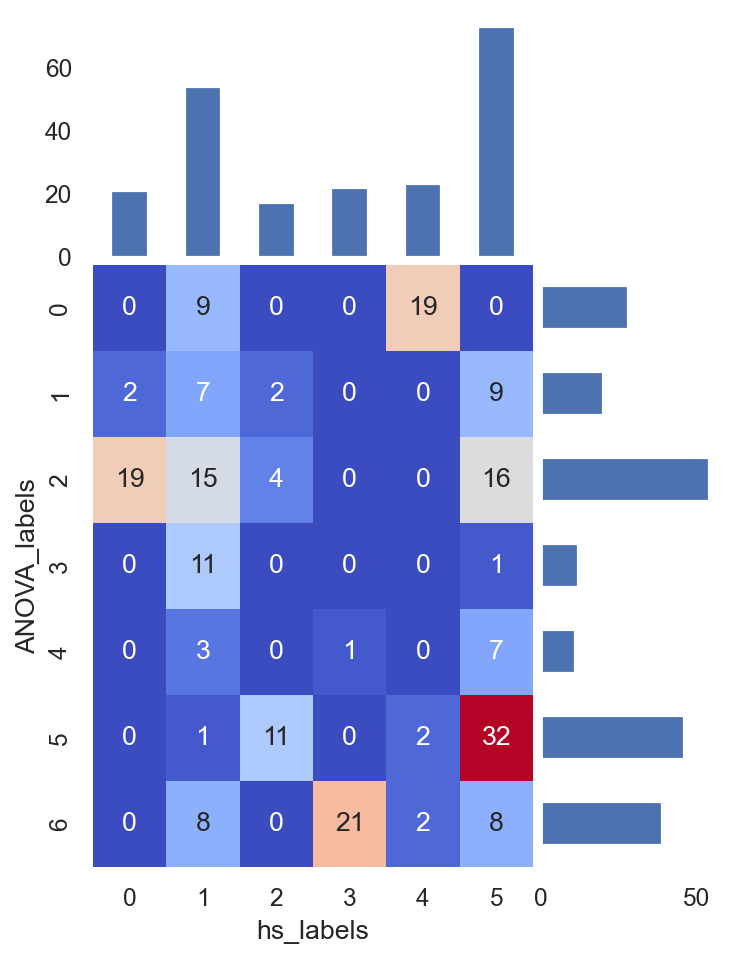

In [207]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [208]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/6 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [209]:
db_name = 'GO_Biological_Process_2021'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [210]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
regulation of tumor necrosis factor superfamily...     1  0.000086   
postsynaptic density organization (GO:0097106)         2  0.000086   
regulation of interleukin-12 production (GO:003...     3  0.000512   
heterophilic cell-cell adhesion via plasma memb...     4  0.000512   
neuron projection extension (GO:1990138)               5  0.002904   

                                                       Z-score  \
Term                                                             
regulation of tumor necrosis factor superfamily...  282.473684   
postsynaptic density organization (GO:0097106)      282.473684   
regulation of interleukin-12 production (GO:003...   80.631579   
heterophilic cell-cell adhesion via plasma memb...   80.631579   
neuron projection extension (GO:1990138)             29.639889   

                                                    Combined score  \
Term                                                                 
regulation of tumor necrosis factor superfamily...     2643.148780   
postsynaptic density organization (GO:0097106)         2643.148780   
regulation of interleukin-12 production (GO:003...      610.956595   
heterophilic cell-cell adhesion via plasma memb...      610.956595   
neuron projection extension (GO:1990138)                173.148141   

                                                   Overlapping genes  \
Term                                                                   
regulation of tumor necrosis factor superfamily...     [CD47, FOXP1]   
postsynaptic density organization (GO:0097106)      [TMEM108, NRXN2]   
regulation of interleukin-12 production (GO:003...     [CD47, FOXP1]   
heterophilic cell-cell adhesion via plasma memb...   [IGSF21, ALCAM]   
neuron projection extension (GO:1990138)            [ALCAM, TMEM108]   

                                                    Adjusted P-value  \
Term                                                                   
regulation of tumor necrosis factor superfamily...          0.011614   
postsynaptic density organization (GO:0097106)              0.011614   
regulation of interleukin-12 production (GO:003...          0.034434   
heterophilic cell-cell adhesion via plasma memb...          0.034434   
neuron projection extension (GO:1990138)                    0.082433   

                                                    Old p-value  \
Term                                                              
regulation of tumor necrosis factor superfamily...            0   
postsynaptic density organization (GO:0097106)                0   
regulation of interleukin-12 production (GO:003...            0   
heterophilic cell-cell adhesion via plasma memb...            0   
neuron projection extension (GO:1990138)                      0   

                                                    Old adjusted p-value  \
Term                                                                       
regulation of tumor necrosis factor superfamily...                     0   
postsynaptic density organization (GO:0097106)                         0   
regulation of interleukin-12 production (GO:003...                     0   
heterophilic cell-cell adhesion via plasma memb...                     0   
neuron projection extension (GO:1990138)                               0   

                                                    num_overlap_genes  \
Term                                                                    
regulation of tumor necrosis factor superfamily...                  2   
postsynaptic density organization (GO:0097106)                      2   
regulation of interleukin-12 production (GO:003...                  2   
heterophilic cell-cell adhesion via plasma memb...                  2   
neuron projection extension (GO:1990138)                            2   

                                                    neg_log10(p_adj)  \
Term      

In [211]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

4

In [212]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

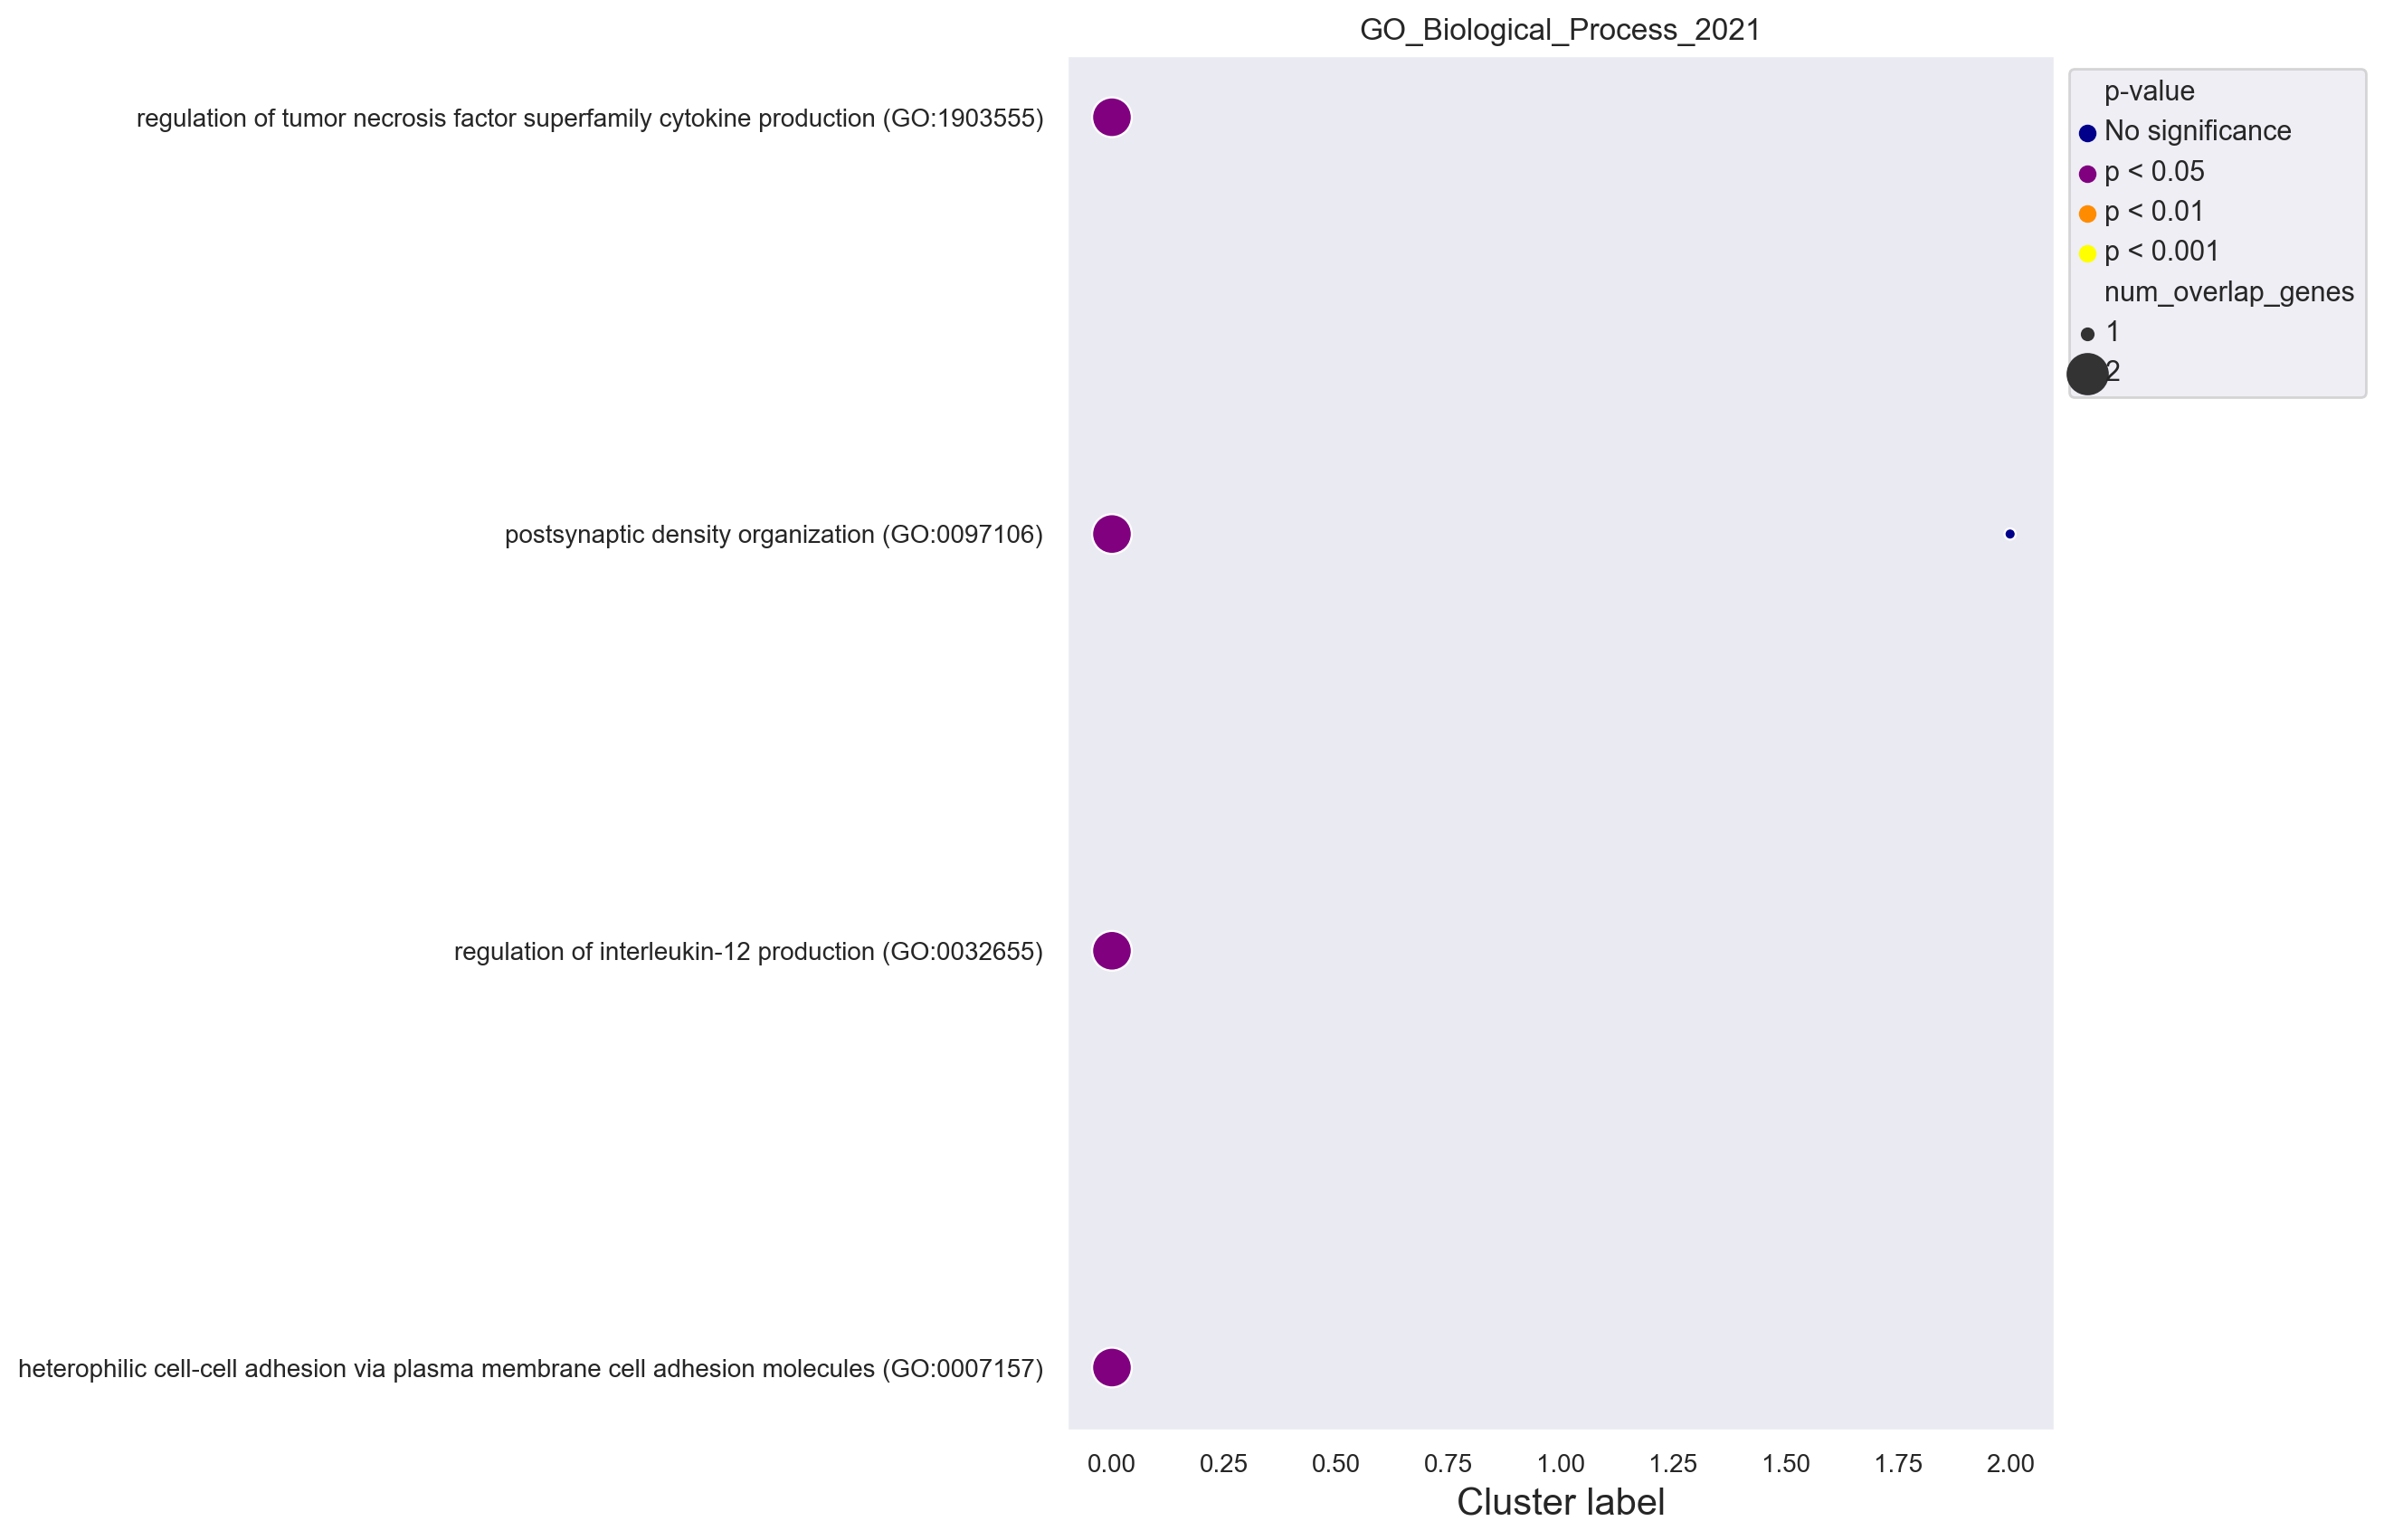

In [213]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [214]:
db_name = 'Azimuth_Cell_Types_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [215]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  Z-score  \
Term                                                                          
SST+ OR5AH1P+ Layer 3-5 GABAergic Neuron CL0000617     1  0.007778    268.4   
Layer 6 Glutamatergic Neuron, Intratelencephalo...     2  0.007778    268.4   
FEZF2+ LPO+ Layer 5-6 Glutamatergic Neuron CL00...     3  0.007778    268.4   
PVALB+ MEPE+ Layer 5-6 GABAergic Neuron CL0000617      4  0.007778    268.4   
Basophil/Mast 1 CL0000766                              5  0.007778    268.4   

                                                    Combined score  \
Term                                                                 
SST+ OR5AH1P+ Layer 3-5 GABAergic Neuron CL0000617     1303.484532   
Layer 6 Glutamatergic Neuron, Intratelencephalo...     1303.484532   
FEZF2+ LPO+ Layer 5-6 Glutamatergic Neuron CL00...     1303.484532   
PVALB+ MEPE+ Layer 5-6 GABAergic Neuron CL0000617      1303.484532   
Basophil/Mast 1 CL0000766                              1303.484532   

                                                   Overlapping genes  \
Term                                                                   
SST+ OR5AH1P+ Layer 3-5 GABAergic Neuron CL0000617           [PCDH9]   
Layer 6 Glutamatergic Neuron, Intratelencephalo...           [PTPRK]   
FEZF2+ LPO+ Layer 5-6 Glutamatergic Neuron CL00...           [ALCAM]   
PVALB+ MEPE+ Layer 5-6 GABAergic Neuron CL0000617            [PCDH9]   
Basophil/Mast 1 CL0000766                                   [GNPTAB]   

                                                    Adjusted P-value  \
Term                                                                   
SST+ OR5AH1P+ Layer 3-5 GABAergic Neuron CL0000617            0.0137   
Layer 6 Glutamatergic Neuron, Intratelencephalo...            0.0137   
FEZF2+ LPO+ Layer 5-6 Glutamatergic Neuron CL00...            0.0137   
PVALB+ MEPE+ Layer 5-6 GABAergic Neuron CL0000617             0.0137   
Basophil/Mast 1 CL0000766                                     0.0137   

                                                    Old p-value  \
Term                                                              
SST+ OR5AH1P+ Layer 3-5 GABAergic Neuron CL0000617            0   
Layer 6 Glutamatergic Neuron, Intratelencephalo...            0   
FEZF2+ LPO+ Layer 5-6 Glutamatergic Neuron CL00...            0   
PVALB+ MEPE+ Layer 5-6 GABAergic Neuron CL0000617             0   
Basophil/Mast 1 CL0000766                                     0   

                                                    Old adjusted p-value  \
Term                                                                       
SST+ OR5AH1P+ Layer 3-5 GABAergic Neuron CL0000617                     0   
Layer 6 Glutamatergic Neuron, Intratelencephalo...                     0   
FEZF2+ LPO+ Layer 5-6 Glutamatergic Neuron CL00...                     0   
PVALB+ MEPE+ Layer 5-6 GABAergic Neuron CL0000617                      0   
Basophil/Mast 1 CL0000766                                              0   

                                                    num_overlap_genes  \
Term                                                                    
SST+ OR5AH1P+ Layer 3-5 GABAergic Neuron CL0000617                  1   
Layer 6 Glutamatergic Neuron, Intratelencephalo...                  1   
FEZF2+ LPO+ Layer 5-6 Glutamatergic Neuron CL00...                  1   
PVALB+ MEPE+ Layer 5-6 GABAergic Neuron CL0000617                   1   
Basophil/Mast 1 CL0000766                                           1   

                                                    neg_log10(p_adj)  \
Term                                                                   
SST+ OR5AH1P+ Layer 3-5 GABAergic Neuron CL0000617          1.863284   
Layer 6 Glutamatergic Neuron, Intratelencephalo...          1.863284   
FEZF2+ LPO+ Layer 5-6 Glutamatergic Neuron CL00...          1.863284   
PVALB+ MEPE+ Layer 5-6 GABAergic Neuron CL0000617           1.863284   
Basophil/Mast 1 CL0000766                         

In [216]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

36

In [217]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

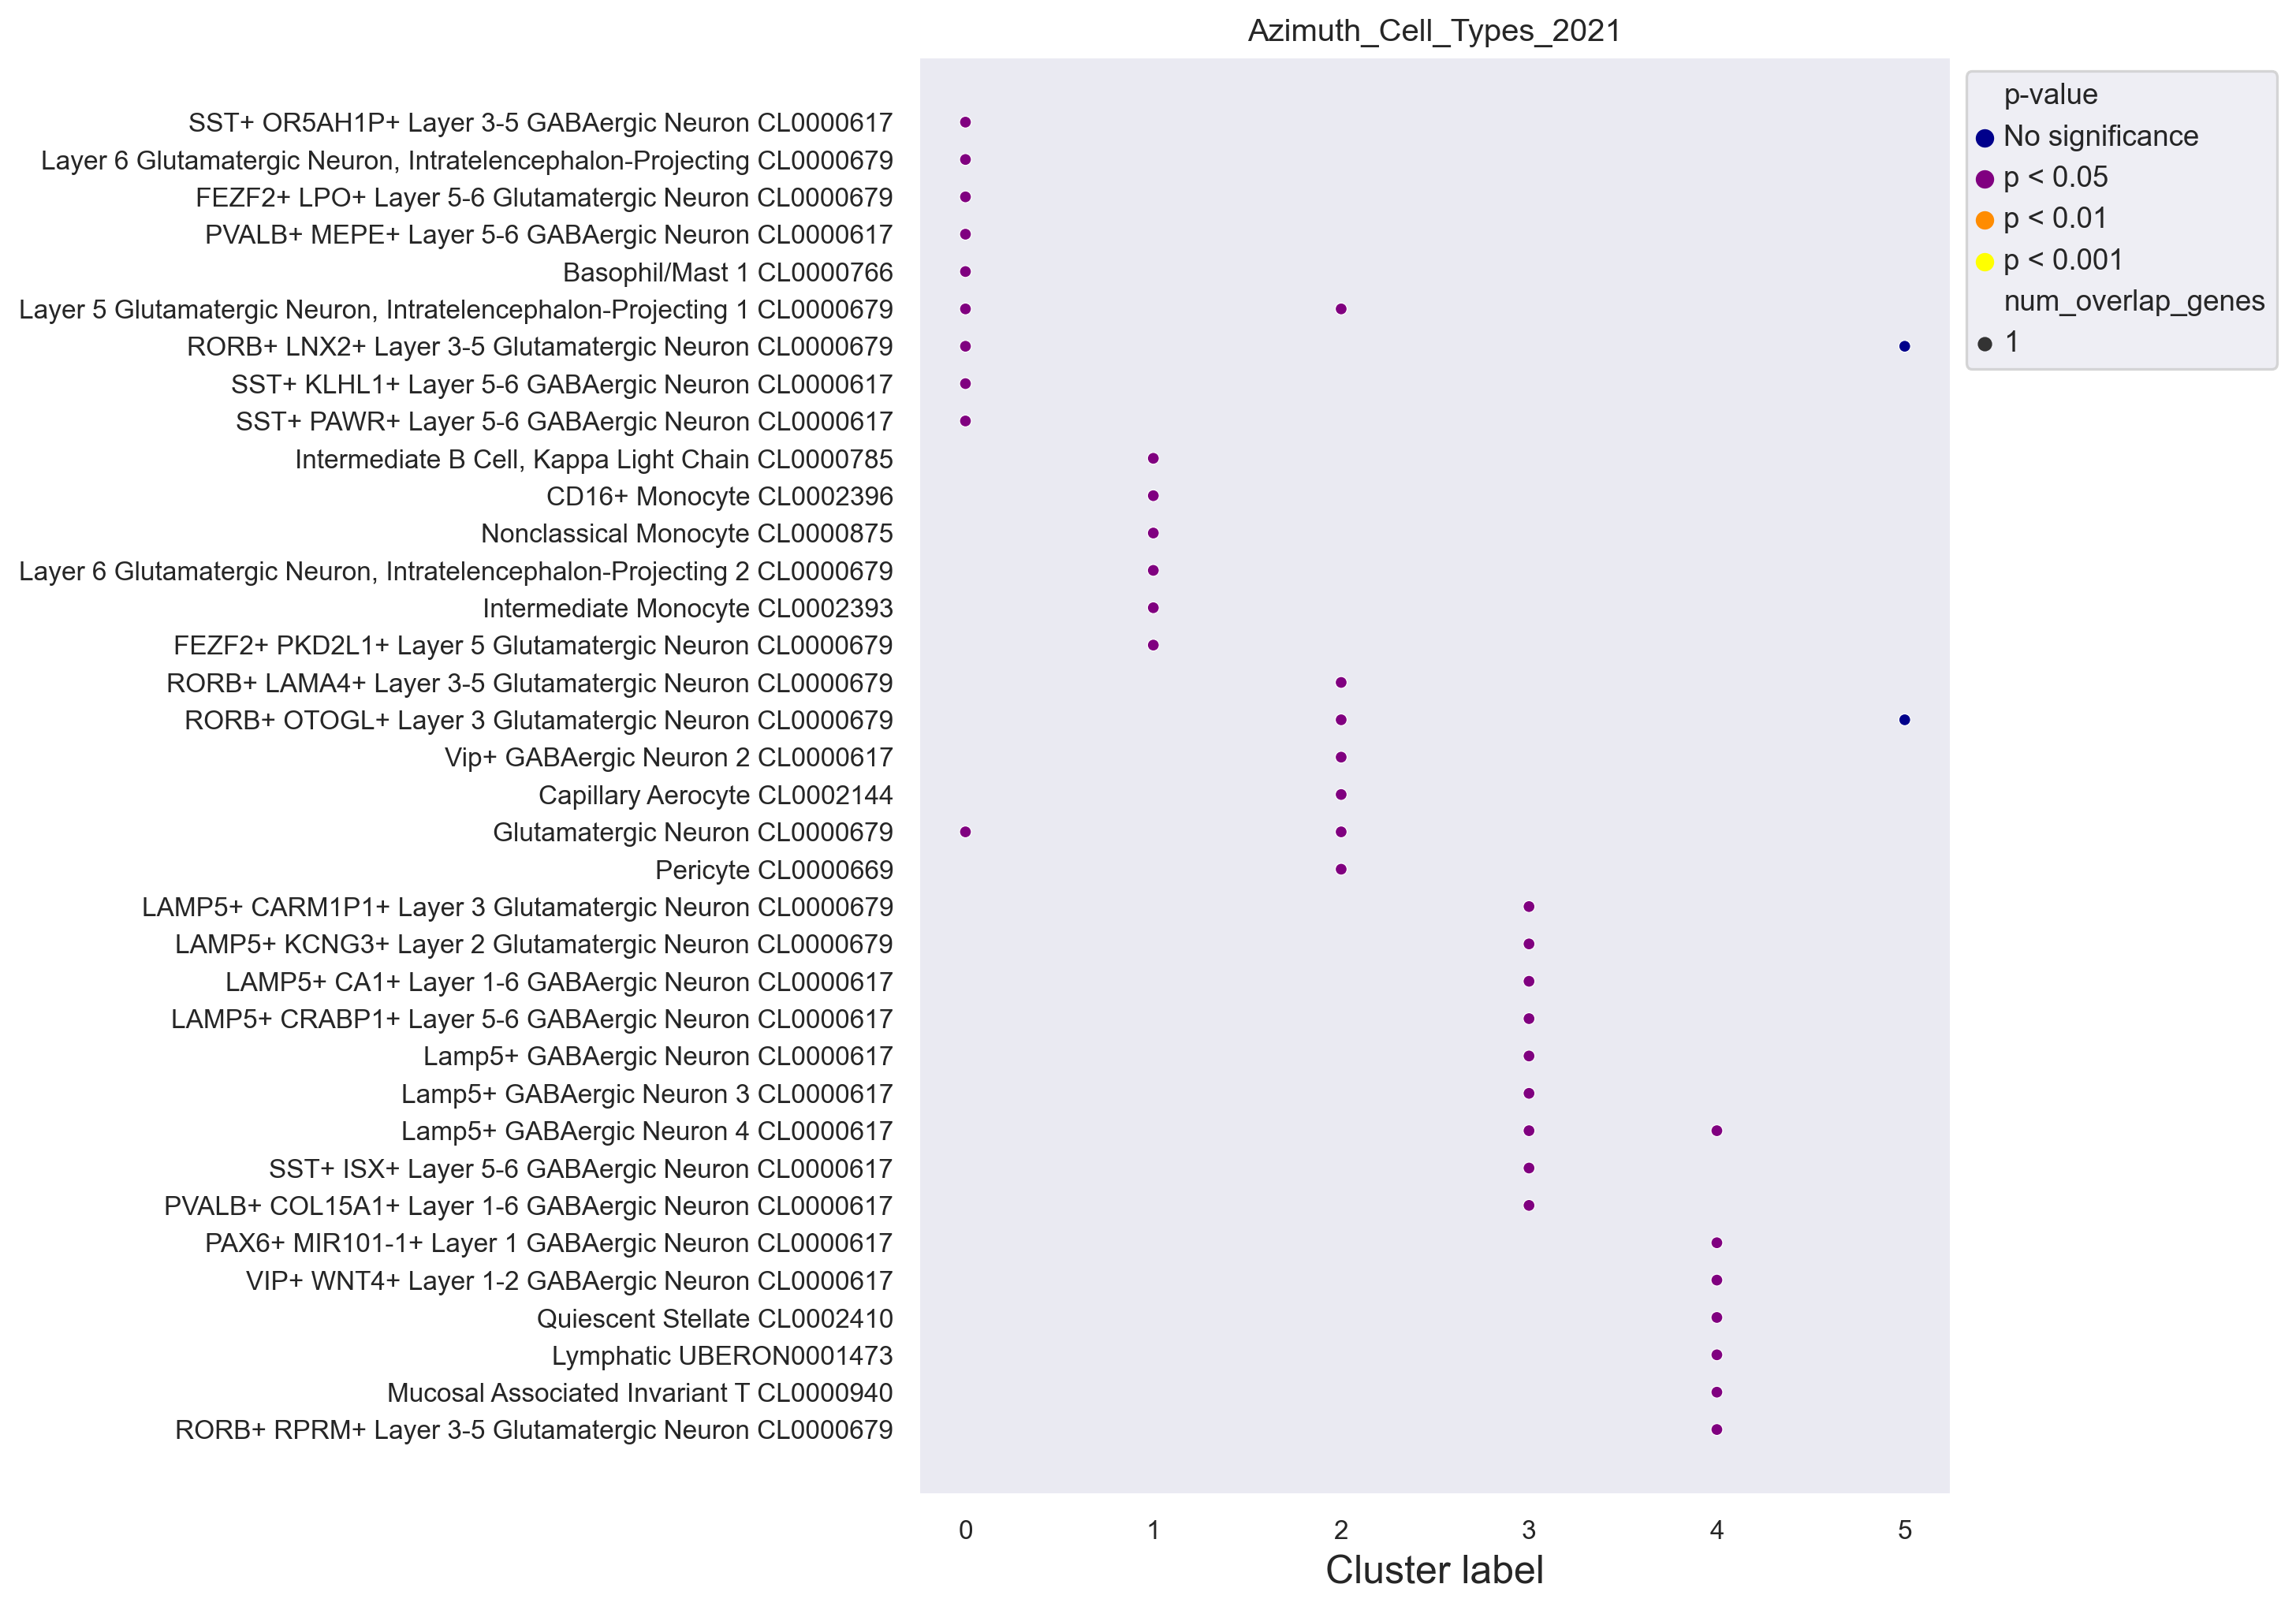

In [218]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [219]:
db_name = 'MGI_Mammalian_Phenotype_Level_4_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [220]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
abnormal hippocampus granule cell morphology MP...     1  0.000215   
decreased prepulse inhibition MP:0009142               2  0.000381   
abnormal neuron physiology MP:0004811                  3  0.000426   
abnormal CNS synaptic transmission MP:0002206          4  0.000494   
abnormal long term object recognition memory MP...     5  0.001679   

                                                       Z-score  \
Term                                                             
abnormal hippocampus granule cell morphology MP...  141.184211   
decreased prepulse inhibition MP:0009142             14.120321   
abnormal neuron physiology MP:0004811                24.689815   
abnormal CNS synaptic transmission MP:0002206        23.381579   
abnormal long term object recognition memory MP...   40.263158   

                                                    Combined score  \
Term                                                                 
abnormal hippocampus granule cell morphology MP...     1192.379392   
decreased prepulse inhibition MP:0009142                111.168607   
abnormal neuron physiology MP:0004811                   191.634255   
abnormal CNS synaptic transmission MP:0002206           177.997840   
abnormal long term object recognition memory MP...      257.265766   

                                                                   Overlapping genes  \
Term                                                                                   
abnormal hippocampus granule cell morphology MP...                 [TMEM108, ATP1A3]   
decreased prepulse inhibition MP:0009142            [IGSF21, PCDH9, TMEM108, ATP1A3]   
abnormal neuron physiology MP:0004811                         [SYT1, DPYSL5, ATP1A3]   
abnormal CNS synaptic transmission MP:0002206                [SYT1, TMEM108, ATP1A3]   
abnormal long term object recognition memory MP...                   [PCDH9, ATP1A3]   

                                                    Adjusted P-value  \
Term                                                                   
abnormal hippocampus granule cell morphology MP...          0.031747   
decreased prepulse inhibition MP:0009142                    0.031747   
abnormal neuron physiology MP:0004811                       0.031747   
abnormal CNS synaptic transmission MP:0002206               0.031747   
abnormal long term object recognition memory MP...          0.080369   

                                                    Old p-value  \
Term                                                              
abnormal hippocampus granule cell morphology MP...            0   
decreased prepulse inhibition MP:0009142                      0   
abnormal neuron physiology MP:0004811                         0   
abnormal CNS synaptic transmission MP:0002206                 0   
abnormal long term object recognition memory MP...            0   

                                                    Old adjusted p-value  \
Term                                                                       
abnormal hippocampus granule cell morphology MP...                     0   
decreased prepulse inhibition MP:0009142                               0   
abnormal neuron physiology MP:0004811                                  0   
abnormal CNS synaptic transmission MP:0002206                          0   
abnormal long term object recognition memory MP...                     0   

                                                    num_overlap_genes  \
Term                                                                    
abnormal hippocampus granule cell morphology MP...                  2   
decreased prepulse inhibition MP:0009142                            4   
abnormal neuron physiology MP:0004811                               3   
abnormal CNS synaptic transmission MP:0002206                       3   
abnormal long term object recognition memory

In [221]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

12

In [222]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

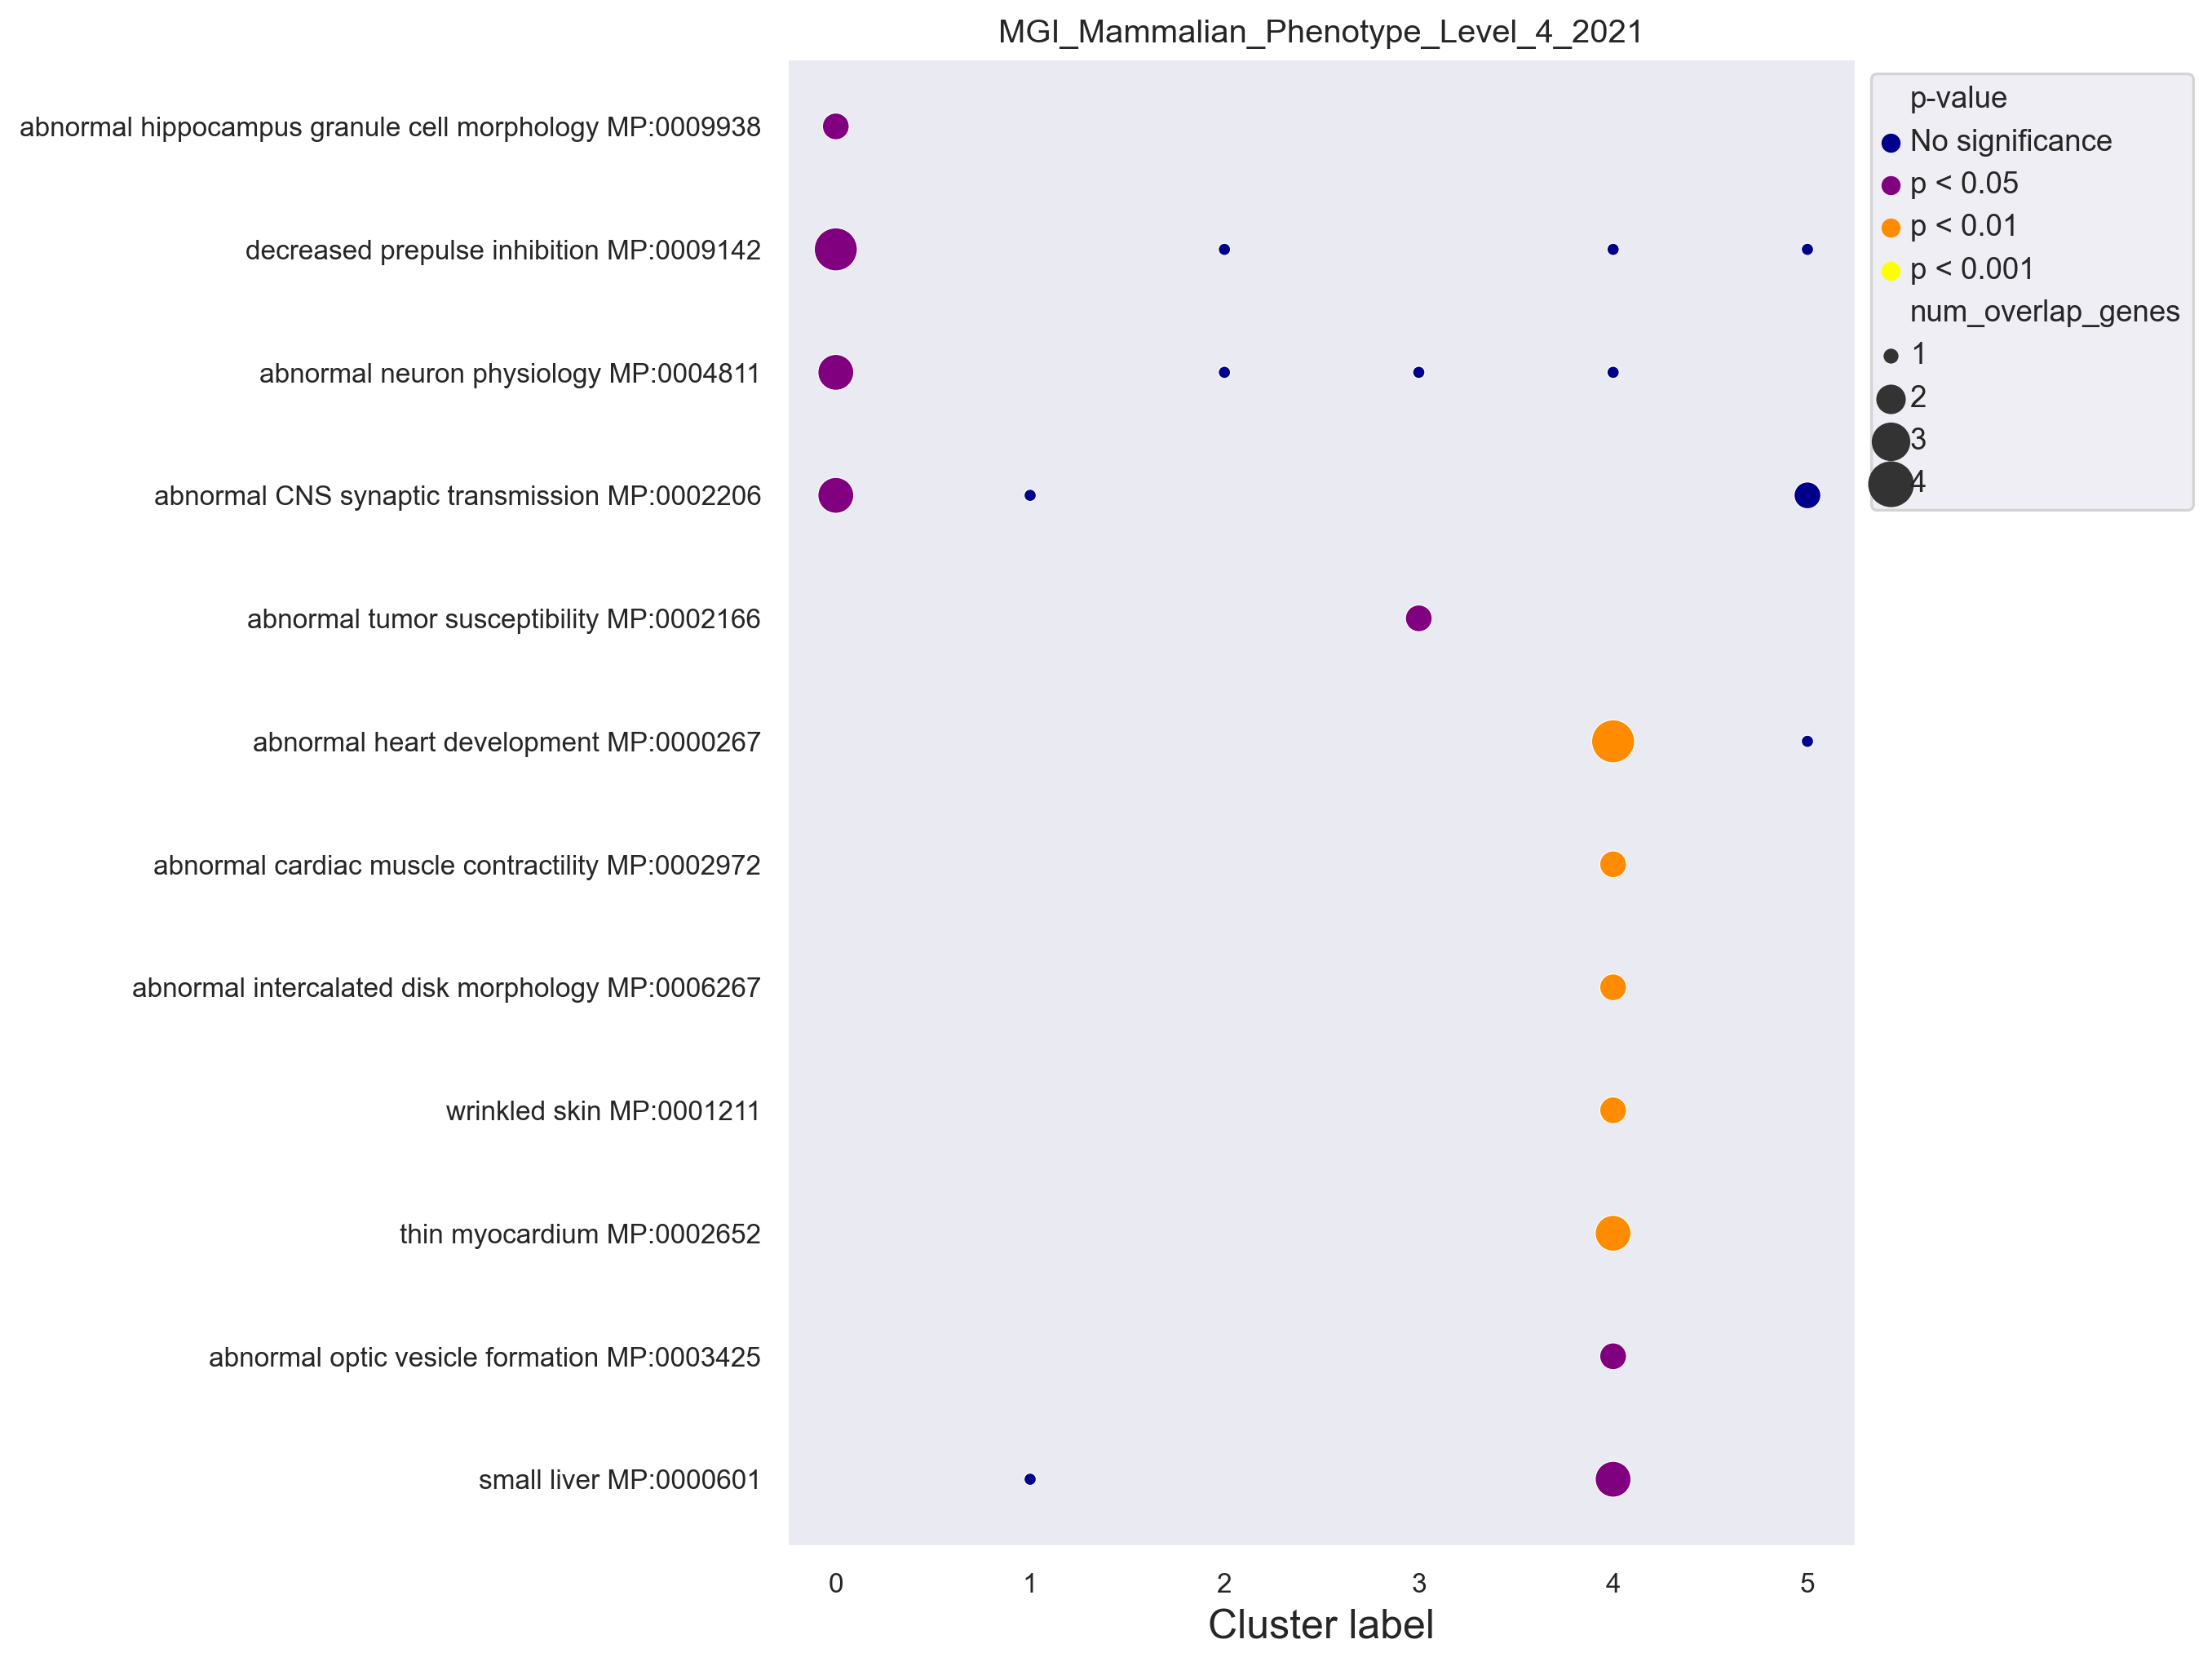

In [223]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [224]:
db_name = 'Reactome_2022'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [225]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Neurexins And Neuroligins R-HSA-6794361                1  0.003187   
Cardiac Conduction R-HSA-5576891                       2  0.007962   
Protein-protein Interactions At Synapses R-HSA-...     3  0.008411   
Neurotoxicity Of Clostridium Toxins R-HSA-168799       4  0.011645   
L1CAM Interactions R-HSA-373760                        5  0.015230   

                                                       Z-score  \
Term                                                             
Neurexins And Neuroligins R-HSA-6794361              28.152632   
Cardiac Conduction R-HSA-5576891                     17.020734   
Protein-protein Interactions At Synapses R-HSA-...   16.517028   
Neurotoxicity Of Clostridium Toxins R-HSA-168799    134.175000   
L1CAM Interactions R-HSA-373760                      11.919373   

                                                    Combined score  \
Term                                                                 
Neurexins And Neuroligins R-HSA-6794361                 161.842804   
Cardiac Conduction R-HSA-5576891                         82.262664   
Protein-protein Interactions At Synapses R-HSA-...       78.922790   
Neurotoxicity Of Clostridium Toxins R-HSA-168799        597.466427   
L1CAM Interactions R-HSA-373760                          49.876754   

                                                   Overlapping genes  \
Term                                                                   
Neurexins And Neuroligins R-HSA-6794361                [SYT1, NRXN2]   
Cardiac Conduction R-HSA-5576891                     [ATP1A3, SCN3A]   
Protein-protein Interactions At Synapses R-HSA-...     [SYT1, NRXN2]   
Neurotoxicity Of Clostridium Toxins R-HSA-168799              [SYT1]   
L1CAM Interactions R-HSA-373760                       [ALCAM, SCN3A]   

                                                    Adjusted P-value  \
Term                                                                   
Neurexins And Neuroligins R-HSA-6794361                     0.133067   
Cardiac Conduction R-HSA-5576891                            0.133067   
Protein-protein Interactions At Synapses R-HSA-...          0.133067   
Neurotoxicity Of Clostridium Toxins R-HSA-168799            0.133067   
L1CAM Interactions R-HSA-373760                             0.133067   

                                                    Old p-value  \
Term                                                              
Neurexins And Neuroligins R-HSA-6794361                       0   
Cardiac Conduction R-HSA-5576891                              0   
Protein-protein Interactions At Synapses R-HSA-...            0   
Neurotoxicity Of Clostridium Toxins R-HSA-168799              0   
L1CAM Interactions R-HSA-373760                               0   

                                                    Old adjusted p-value  \
Term                                                                       
Neurexins And Neuroligins R-HSA-6794361                                0   
Cardiac Conduction R-HSA-5576891                                       0   
Protein-protein Interactions At Synapses R-HSA-...                     0   
Neurotoxicity Of Clostridium Toxins R-HSA-168799                       0   
L1CAM Interactions R-HSA-373760                                        0   

                                                    num_overlap_genes  \
Term                                                                    
Neurexins And Neuroligins R-HSA-6794361                             2   
Cardiac Conduction R-HSA-5576891                                    2   
Protein-protein Interactions At Synapses R-HSA-...                  2   
Neurotoxicity Of Clostridium Toxins R-HSA-168799                    1   
L1CAM Interactions R-HSA-373760                                     2   

                                                    neg_log10(p_adj)  \
Term      

In [226]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

20

In [227]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

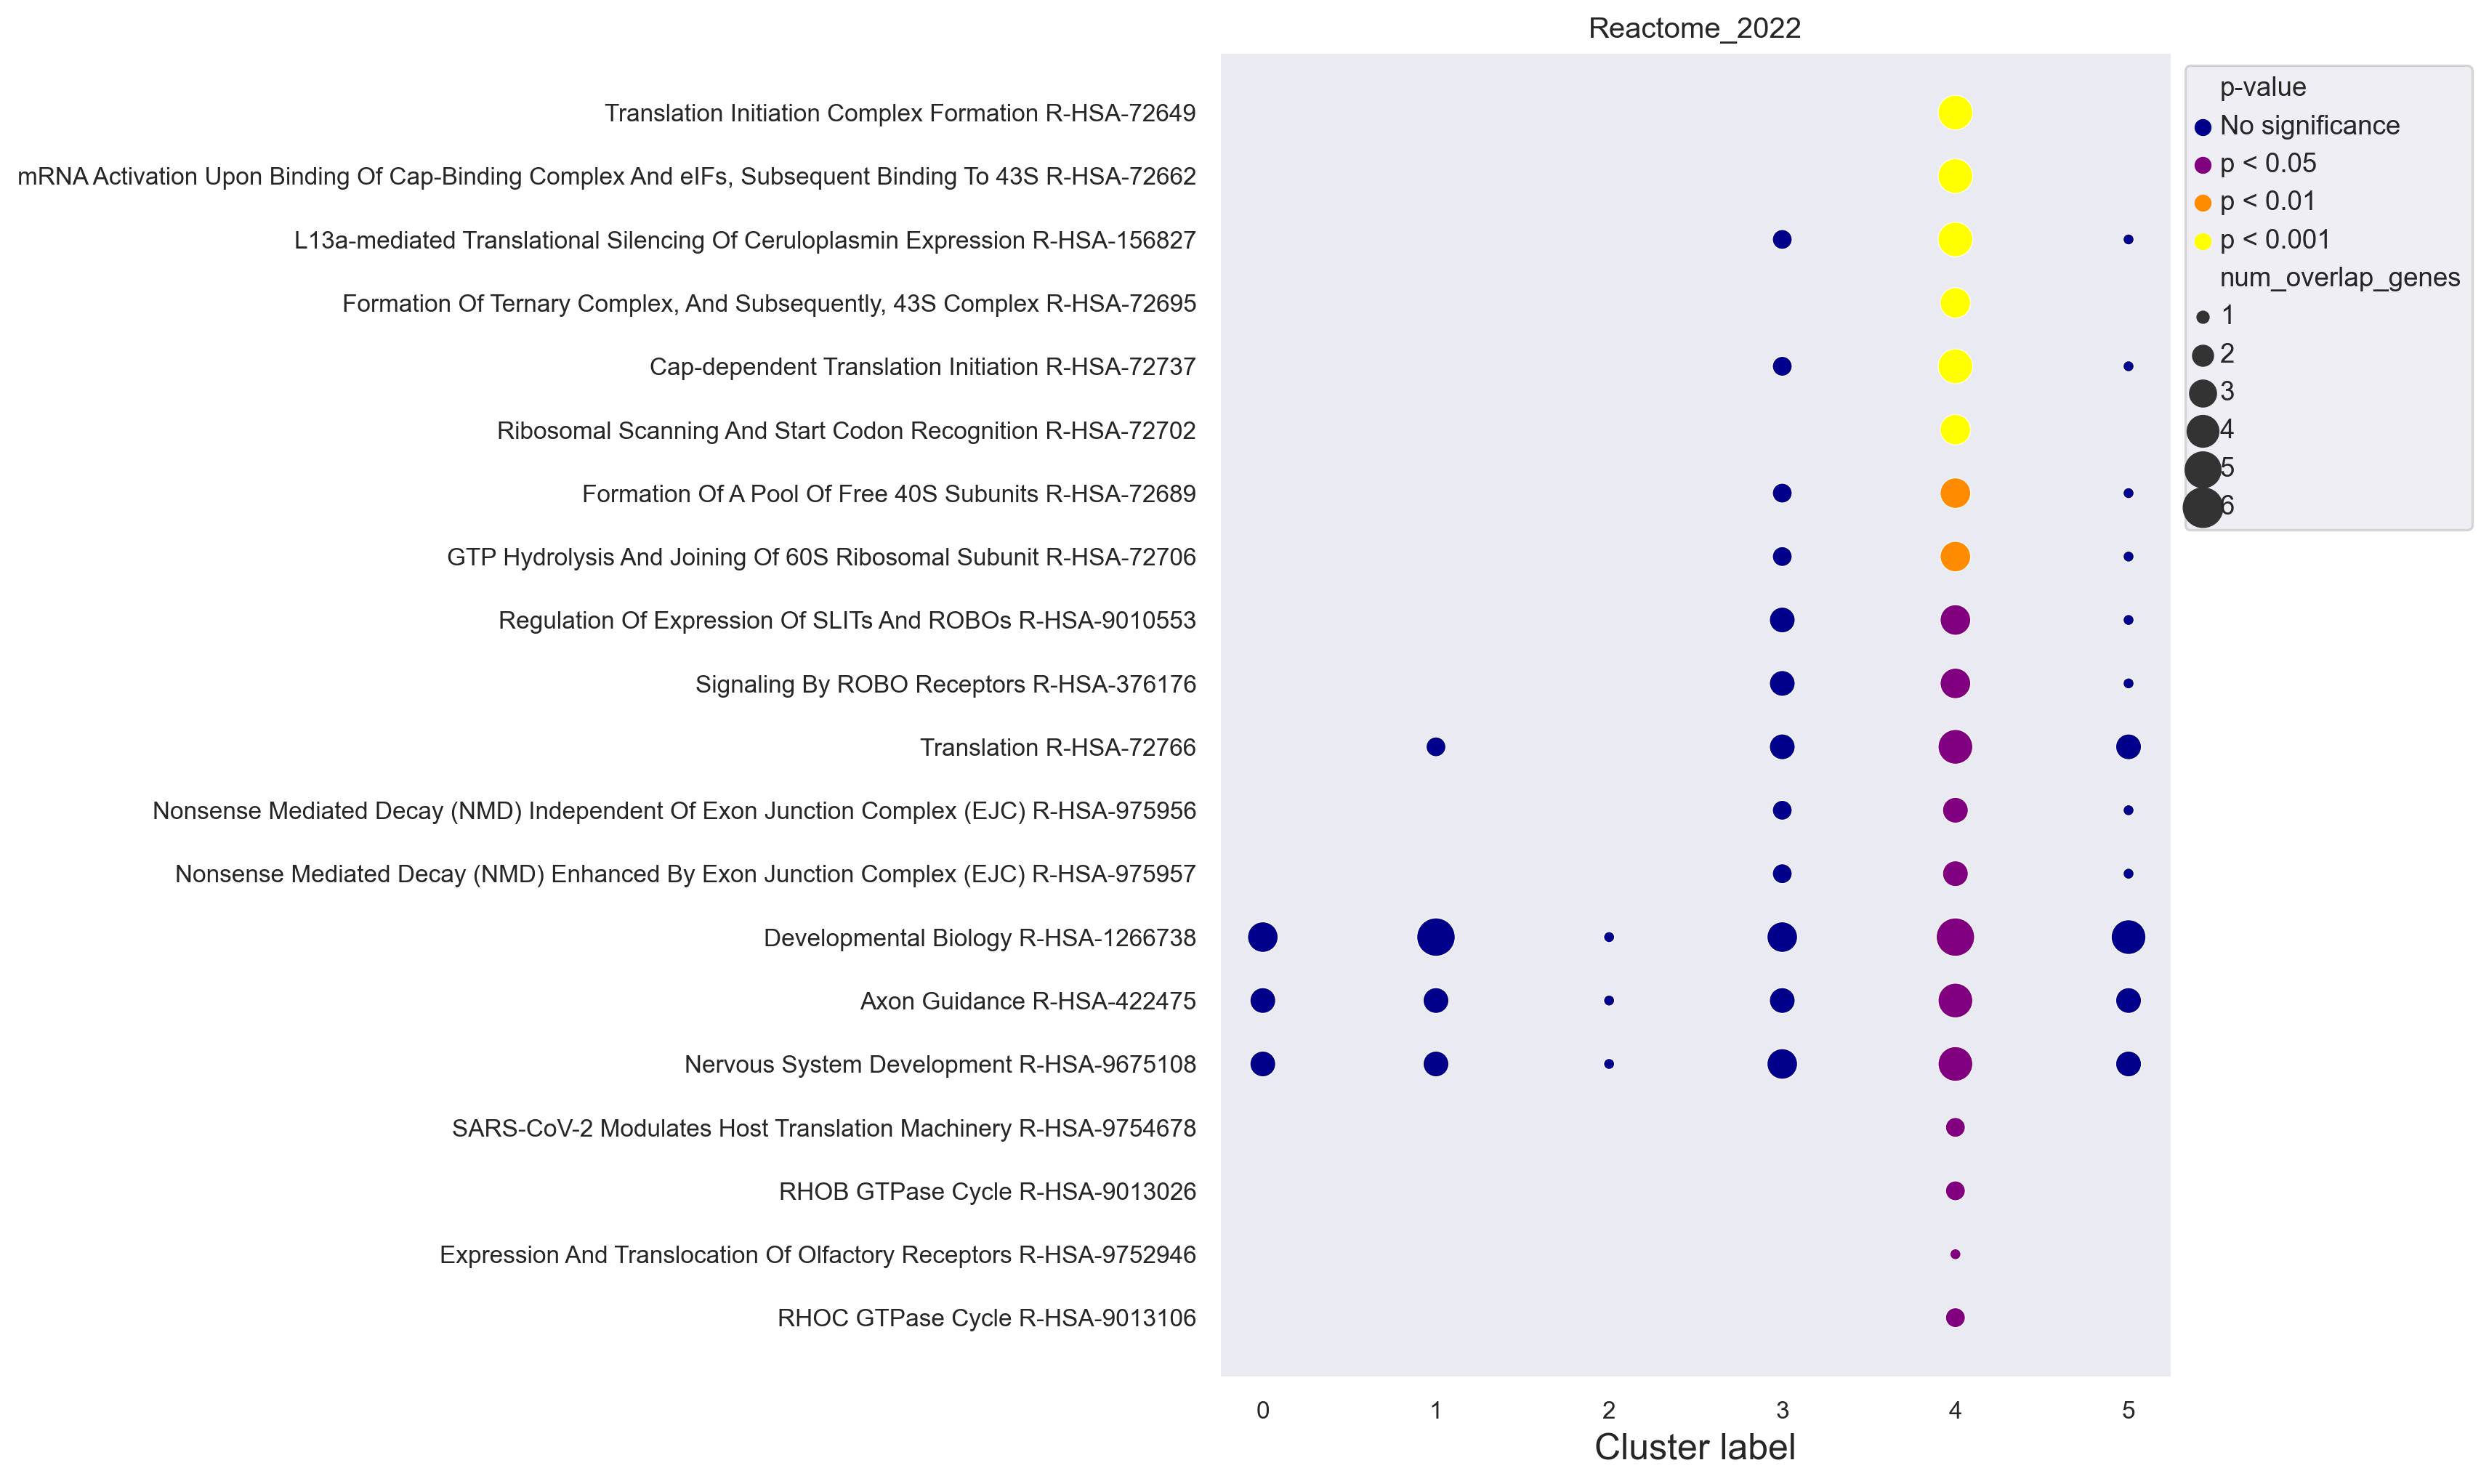

In [228]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [229]:
db_name = 'KEGG_2021_Human'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [230]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                   
Cell adhesion molecules                       1  0.007099  18.125637   
Taste transduction                            2  0.034548  33.506250   
Proximal tubule bicarbonate reclamation       3  0.042070  26.795000   
Aldosterone-regulated sodium reabsorption     4  0.053248  20.600000   
ECM-receptor interaction                      5  0.056946  19.125000   

                                           Combined score Overlapping genes  \
Term                                                                          
Cell adhesion molecules                         89.683253    [ALCAM, NRXN2]   
Taste transduction                             112.761680           [SCN3A]   
Proximal tubule bicarbonate reclamation         84.897818          [ATP1A3]   
Aldosterone-regulated sodium reabsorption       60.415659          [ATP1A3]   
ECM-receptor interaction                        54.805581            [CD47]   

                                           Adjusted P-value  Old p-value  \
Term                                                                       
Cell adhesion molecules                            0.143401            0   
Taste transduction                                 0.143401            0   
Proximal tubule bicarbonate reclamation            0.143401            0   
Aldosterone-regulated sodium reabsorption          0.143401            0   
ECM-receptor interaction                           0.143401            0   

                                           Old adjusted p-value  \
Term                                                              
Cell adhesion molecules                                       0   
Taste transduction                                            0   
Proximal tubule bicarbonate reclamation                       0   
Aldosterone-regulated sodium reabsorption                     0   
ECM-receptor interaction                                      0   

                                           num_overlap_genes  \
Term                                                           
Cell adhesion molecules                                    2   
Taste transduction                                         1   
Proximal tubule bicarbonate reclamation                    1   
Aldosterone-regulated sodium reabsorption                  1   
ECM-receptor interaction                                   1   

                                           neg_log10(p_adj)  cluster_label  
Term                                                                        
Cell adhesion molecules                            0.843448              0  
Taste transduction                                 0.843448              0  
Proximal tubule bicarbonate reclamation            0.843448              0  
Aldosterone-regulated sodium reabsorption          0.843448              0  
ECM-receptor interaction                           0.843448              0

In [231]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

1

In [232]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

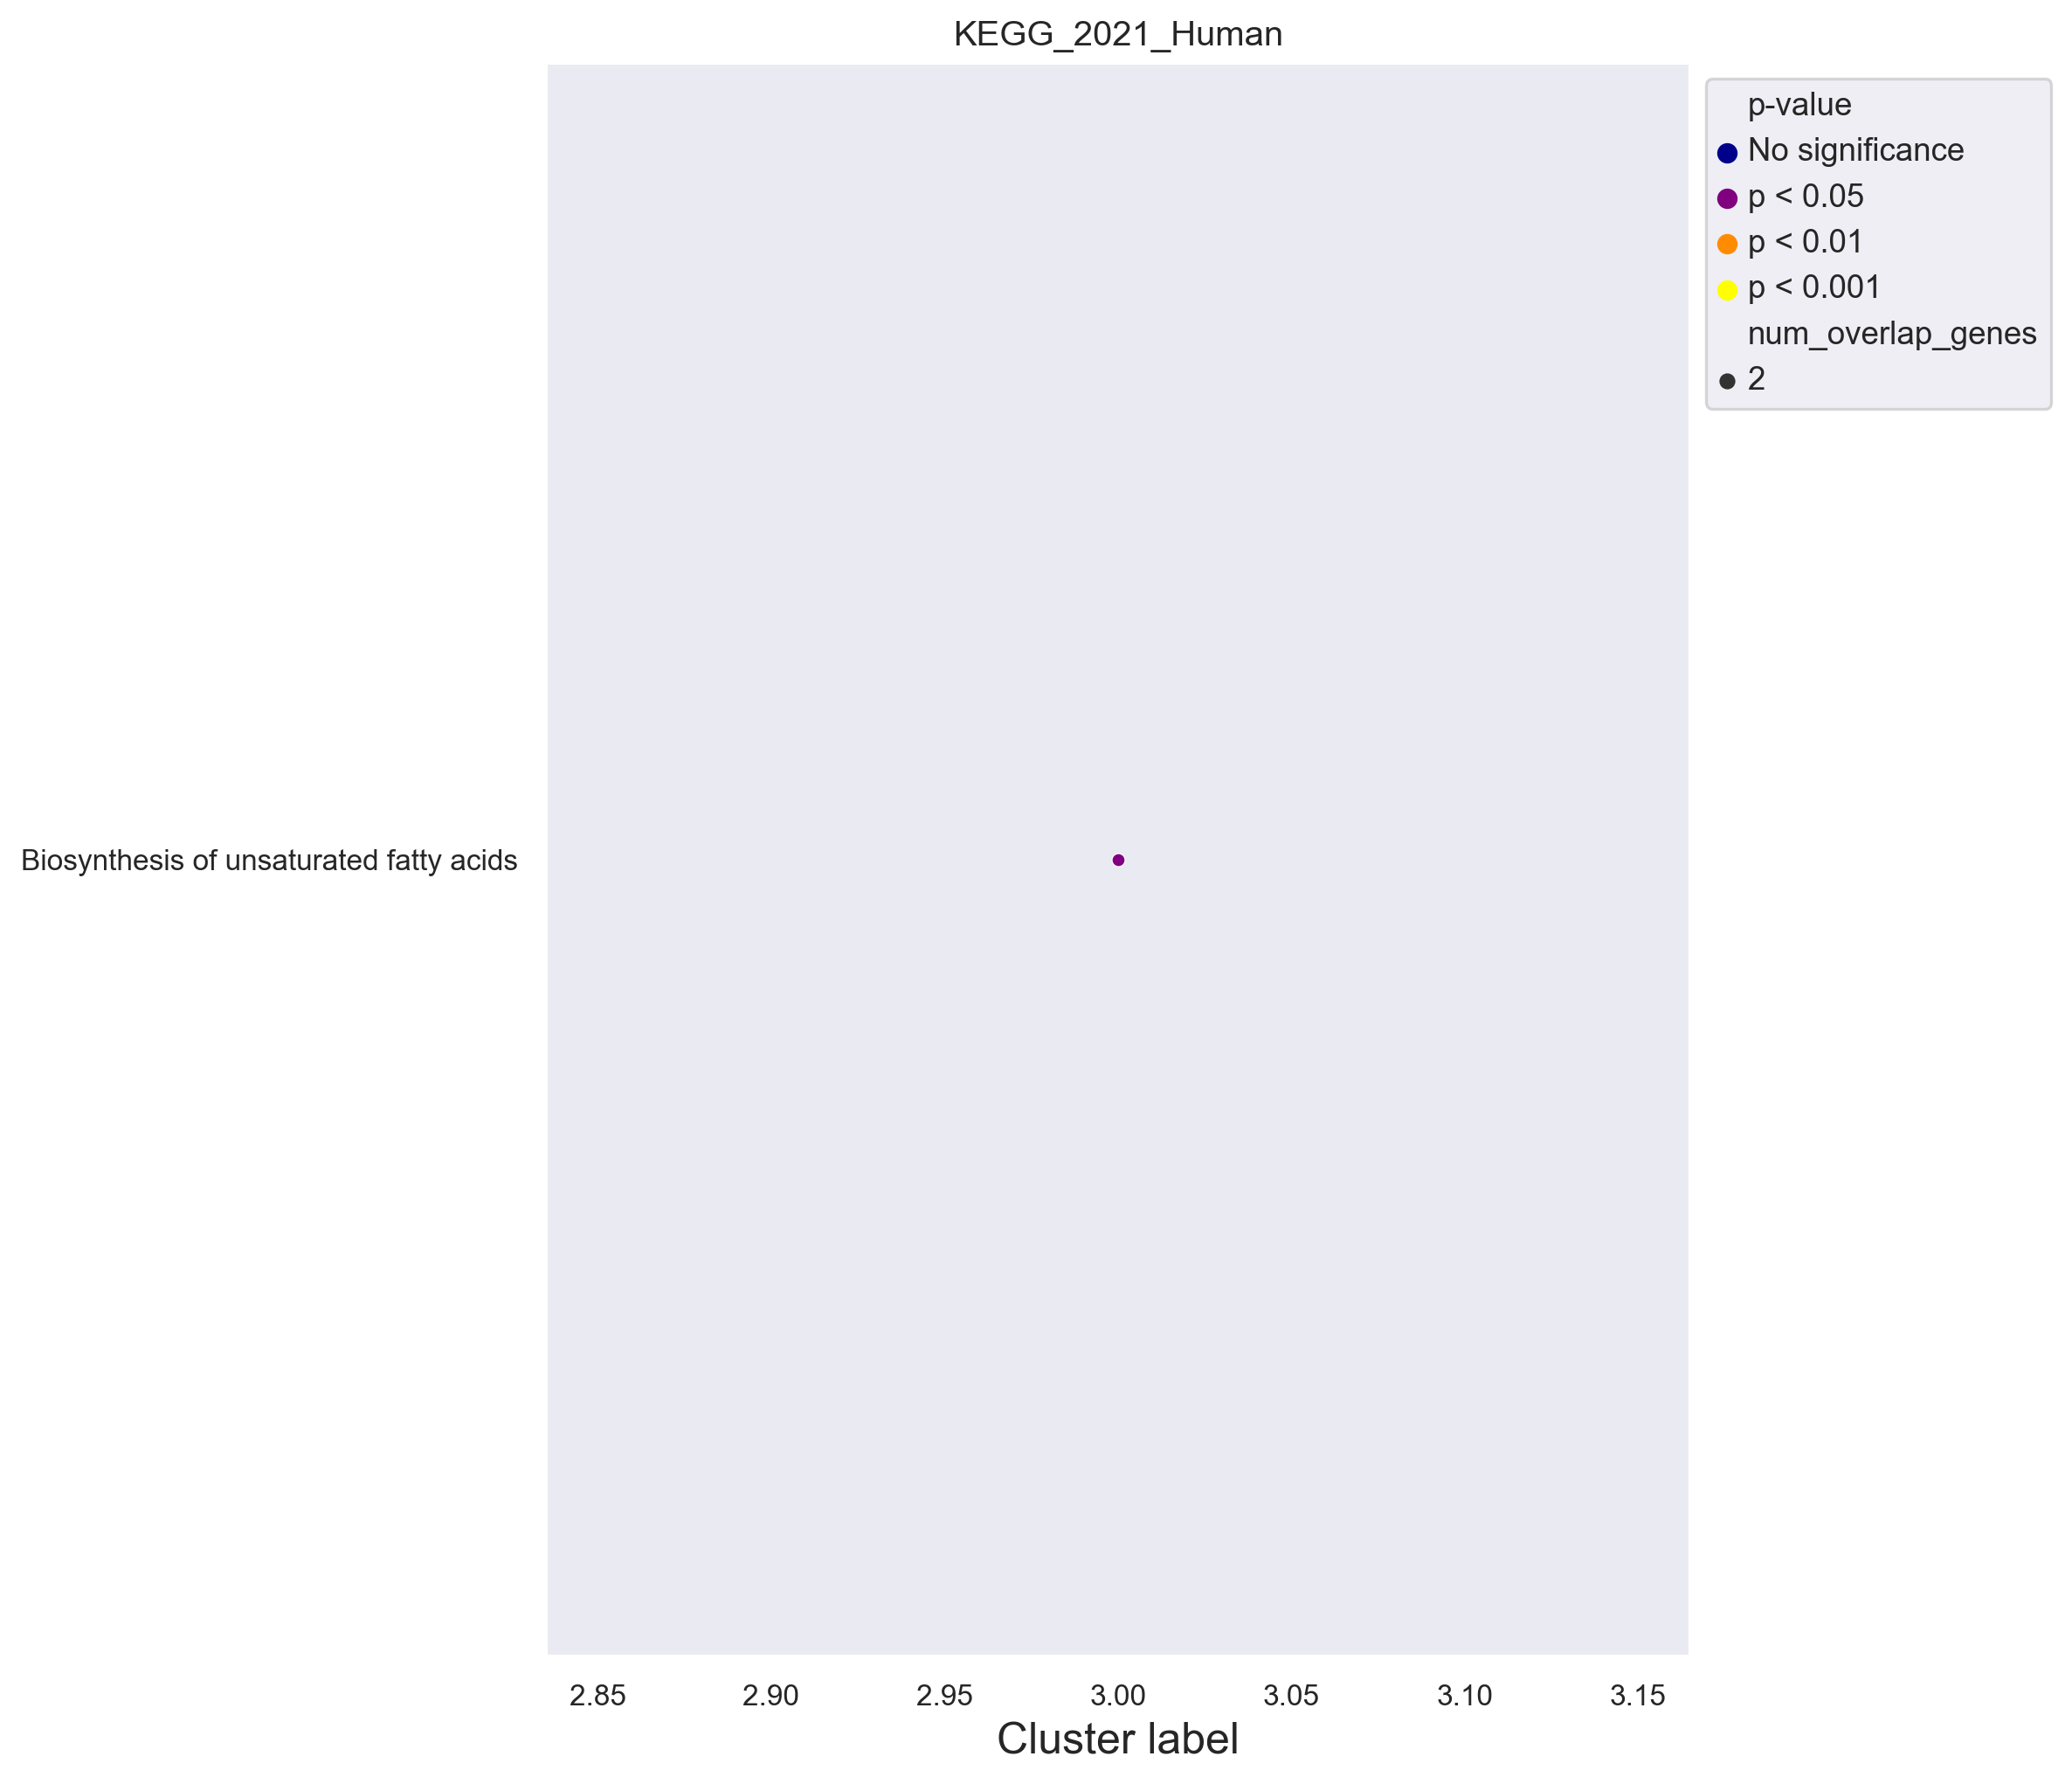

In [233]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))